# Code Space for Debugging of Plotter Code

In [16]:
import base64
import os, io
from datetime import date, datetime, timedelta
import pandas as pd
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from PIL import Image
import numpy as np
import google.cloud.logging
from google.cloud import storage
import logging
from alive_progress import alive_bar

In [17]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../service_account.json'

### Create Date Range 

In [18]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----    CREATE DATERANGE    ----- ----- ----- -----
# Create list of all dates between start_date and end_date
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# ======================================================================

### Truncate CMAP

In [19]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----   TRUNCATE COLORMAP    ----- ----- ----- -----
# Can be used to remove white / black bookended values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
          'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
          cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# ======================================================================

### Plot Temps

In [20]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----      PLOT TEMPS        ----- ----- ----- -----
# Saves each plot to date specific folder in Google Cloud bucket
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def plot_temps(storage_client, locations=[], date=datetime.today().date(), days=[], save_name=''):
    
    # Loop through each graph type to plot
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for d in days:
        # Set figure details
        # ~~~~~~~~~~~~~~~~~~
        plt.figure(figsize=(20,6))
        plt.xlim([0, d -1])
        plt.grid()
        plt.axhline(0, color='black')
        plt.xticks(rotation = 'vertical')
        if d > 30:
            plt.xticks(np.arange(0, d+1, 7.0))  

        if len(locations) == 1:
            plt.title("{} Temperature °C - {} day".format(locations[0]['name'], d))
        else:
            plt.title("Temperature °C - {} day".format(d))

        palette = sns.color_palette("Paired", n_colors=6)
        palette_order = [1, 0, 3, 2, 5, 4]
        palette = [palette[idx] for idx in palette_order]
        hue_order = [850, 700]

        # Loop through each location and plot data on graph
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for location in locations:
            # Create truncated data object with only correct date range
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            mask = (location['data']['Date'] >= str(date - timedelta(days=d))) & (location['data']['Date'] <= str(date))
            plot_data = location['data'].loc[mask]
            
            #print(plot_data)

            # Add data for single location to graph
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if not plot_data.empty:
                g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=plot_data, palette=palette[location['palette_order'][0]: location['palette_order'][1]], hue_order=hue_order)
            else:
                print('Empty dataframe - cannot plot')


        # Rename legend with detailed labels
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        l = plt.legend()
        labels = []
        for location in locations:
            for pressure in [700, 850]:
                labels.append('{} {}'.format(location['name'], pressure))

        # Re-order labels by desc pressure
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if len(locations) == len(palette_order) / 2:
            labels = [labels[idx] for idx in palette_order]
        else:
            labels = ['850', '700']
        for x, label in enumerate(labels):
            l.get_texts()[x].set_text(label)

        # Generate Save Path
        # ~~~~~~~~~~~~~~~~~~
        if not save_name:
            save_name = '{}_temp'.format(locations[0]['name'].lower().replace(' ', ''))

        save_loc = "./figures/temp/{}".format(date.strftime("%Y/%m/%d"))

        if not os.path.isdir(save_loc):
            os.makedirs(save_loc)

        # Publish graph to Google Cloud
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)

        buff = io.BytesIO()
        plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

        blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(date.strftime("%Y/%m/%d"), save_name, d, date.strftime("%Y/%m/%d"))
        blob = bucket.blob(blob_name)
        blob.upload_from_string(buff.getvalue(), content_type='image/png')
        plt.close()
        del buff

# ======================================================================

### Plot Wind

In [21]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----       PLOT WIND        ----- ----- ----- -----
# Saves each plot to date specific folder in Google Cloud bucket
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def plot_wind(storage_client, location, date=datetime.today().date(), days=[]):
    
    # Define color map and truncate to apropriate range
    cmap = cm.viridis_r
    cmap = truncate_colormap(cmap, minval=0, maxval=0.9)
  
    # Loop through each graph type to plot
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for d in days:
        # Create truncated data object with only correct date range
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        try:
            mask = (location['data']['Date'] > str(date - timedelta(days=d))) & (location['data']['Date'] <= str(date))
            plot_data = location['data'].loc[mask]
        except Exception as e:
            print(e)

        # Continue to next loop if df is empty
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if plot_data.empty:
            print('Empty dataframe - cannot plot')
            continue

        # Populate speed and direction vars from DataFrame
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
        wd = plot_data['Wind_Direction'].to_list()
        ws = plot_data['Wind_Speed'].to_list()


        # Plot wind rose for data set
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ax = WindroseAxes.from_ax()
        #ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
        ax.contourf(wd, ws, cmap=cmap)
        ax.set_legend()

        # Save figure
        # ~~~~~~~~~~~
        plt.title("{} Wind - {} day".format(location['name'], d))
        plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)

        # Generate Save Path
        # ~~~~~~~~~~~~~~~~~~
        save_name = '{}_wind'.format(location['name'].lower().replace(' ', ''))

        save_loc = "./figures/wind/{}".format(date)

        if not os.path.isdir(save_loc):
            os.makedirs(save_loc)

        # Save image as webp
        # ~~~~~~~~~~~~~~~~~~
        path = '{}/{}_{}d_{}'.format(save_loc, save_name, d, date)
        plt.savefig('{}.webp'.format(path), format='webp',dpi=150)

        # Publish graph to Google Cloud
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)

        buff = io.BytesIO()
        plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

        blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(date, save_name, d, date)
        blob = bucket.blob(blob_name)
        blob.upload_from_string(buff.getvalue(), content_type='image/png')
        plt.close()
        del buff

# ======================================================================

### Import Weather Data

In [22]:
# -------------------------------------------------------------------------------
# IMPORT DATASET
# Function to import all weather data
# Data Patching completed in this step
# -------------------------------------------------------------------------------
def import_weather_data(storage_client):
    # Connect to Google Cloud Storage
    # -------------------------------
    storage_client = storage.Client()

    # Open Bucket
    # -----------
    bucket_name = 'weather_aurorabc'
    bucket = storage_client.bucket(bucket_name)

    # Open Blob
    # ---------
    blob_name = 'weather_ampm.csv'
    #blob_name = 'backups/weather-2023-09-26.csv'
    blob = bucket.blob(blob_name)

    # Read Weather Data from Blob
    # ---------------------------
    with blob.open("r") as f:
        weather_data = pd.read_csv(f)

    # Cast all data variables to float
    weather_data = weather_data.astype(
        {'Height':'float',
        'Temp':'float',
        'DewPoint':'float',
        'Relative_Humidity':'float',
        'Mean_Mixed_Layer':'float',
        'Wind_Direction':'float',
        'Wind_Speed':'float',
        'Potential_Temp':'float',
        'Equivalent_Potential_Temp':'float',
        'Virtual_Potential_Temp':'float',
        })

    return weather_data

### Main Application Body

In [162]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ----- ----- ----- -----          START         ----- ----- ----- -----
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def main():
    
    weather_data = import_data()


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # DEFINE PLOT ATTRIBITES FOR EACH LOCATION
    #logging.info("Defining plots for each locaiton")
    print("Defining plots for each locaiton")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    locations = [{
        'name': "Vernon",
        'palette_order': [2, 4], # green
        'save_name': "vernon",
        'data': weather_data[weather_data['Station'] == "Vernon"]
    },
    {
        'name': "Port Hardy",
        'palette_order': [4, 6], # red
        'save_name': "porthardy",
        'data': weather_data[weather_data['Station'] == "Port Hardy"]
    },
    {
        'name': "Quillayute",
        'palette_order': [0, 2], # blue
        'save_name': "quillayute",
        'data': weather_data[weather_data['Station'] == "Quillayute"]
    }]

    date = datetime.today().date()
    plot_range = [3, 5, 10, 30, 90, 180]
    plots = [locations[0], locations[1], locations [2]]
    for plot in plots:
        #logging.info("{}: \n{}".format(plot['name'], plot['data'].head(2)))
        print("{}: \n{}".format(plot['name'], plot['data'].head(2)))
        ##logging.info(plots)
        

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATE RANGE OF DATES TO PLOT
    #logging.info("Creating range of dates to plot")
    print("Creating range of dates to plot")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    start_date = datetime(2023, 5, 22)
    end_date = datetime.today()

    dates = []
    for single_date in daterange(start_date, end_date):
        dates.append(single_date.date())

    # Remove dates that already have plots saved
    # ------------------------------------------
    filenames = ['all_10d', 'porthardy_wind_10d']
        
    for date in dates:
        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)

    exists = []
    for f in filenames:
        blob_name = 'graphs/{}/{}_{}.webp'.format(date, f, date)
        blob = bucket.blob(blob_name)
        exists.append(blob.exists())

    if not False in exists:
        dates.remove(date)

    # Limit each run to the latest 10 dates with missing graphs
    dates = dates[-10:]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATE AND SAVE PLOTS TO BUCKET
    #logging.info("Creating plots for each date and saving to bucket")
    print("Creating plots for each date and saving to bucket")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    print("Creating Plots for dates...")
    print(dates)
    with alive_bar(len(dates), force_tty=True) as bar:

        for date in dates:
            try:
                # Plot all temps on single graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                print("Plotting all temps for {}".format(date.strftime("%Y/%m/%d")))
                plot_temps(storage_client, plots, date, plot_range, 'all')
            except Exception as e:
                #logging.error(e)
                print(e)
                #logging.warning("Unable to pot ALL TEMPS for {}".format(date))
                print("Unable to pot ALL TEMPS for {}".format(date.strftime("%Y/%m/%d")))

            try:
                # Plot each temp on individual graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                print("Plotting temps for each station individually for {}".format(date.strftime("%Y/%m/%d")))
                for plot in plots:
                    plot_temps(storage_client, [plot], date, plot_range)
            except Exception as e:
                #logging.error(e)
                print(e)
                #logging.warning("Unable to plot INDIVIDUAL TEMPS for {}".format(date))
                print("Unable to plot INDIVIDUAL TEMPS for {}".format(date.strftime("%Y/%m/%d")))
                # Plot each wind on individual graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            try:
                print("Plotting wind for {}".format(date.strftime("%Y/%m/%d")))
                for plot in plots:
                    plot_wind(storage_client, plot, plot_range=plot_range)
            except Exception as e:
                #logging.error(e)
                print(e)
                #logging.warning("Unable to plot WIND for {}".format(date))
                print("Unable to plot WIND for {}".format(date.strftime("%Y/%m/%d")))
                print(plot)
                break

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ----- ----- ----- -----           END          ----- ----- ----- -----
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Patching Complete
Defining plots for each locaiton
Vernon: 
         Date Station  Pressure  Height  Temp  DewPoint  Relative_Humidity  \
4  2020-01-01  Vernon       700  2880.0  -5.5      -7.0               89.0   
5  2020-01-01  Vernon       850     NaN   NaN       NaN                NaN   

   Mean_Mixed_Layer  Wind_Direction  Wind_Speed  Potential_Temp  \
4              3.25           260.0      94.452           296.4   
5               NaN             NaN         NaN             NaN   

   Equivalent_Potential_Temp  Virtual_Potential_Temp  
4                      306.3                   296.9  
5                        NaN                     NaN  
Port Hardy: 
         Date     Station  Pressure  Height  Temp  DewPoint  \
0  2020-01-01  Port Hardy       700  2856.0  -4.3      -5.8   
1  2020-01-01  Port Hardy       850  1301.0   3.4       1.9   

   Relative_Humidity  Mean_Mixed_Layer  Wind_Direction  Wind_Speed  \
0               89.0              3.56           250.0      87.04

KeyboardInterrupt: 

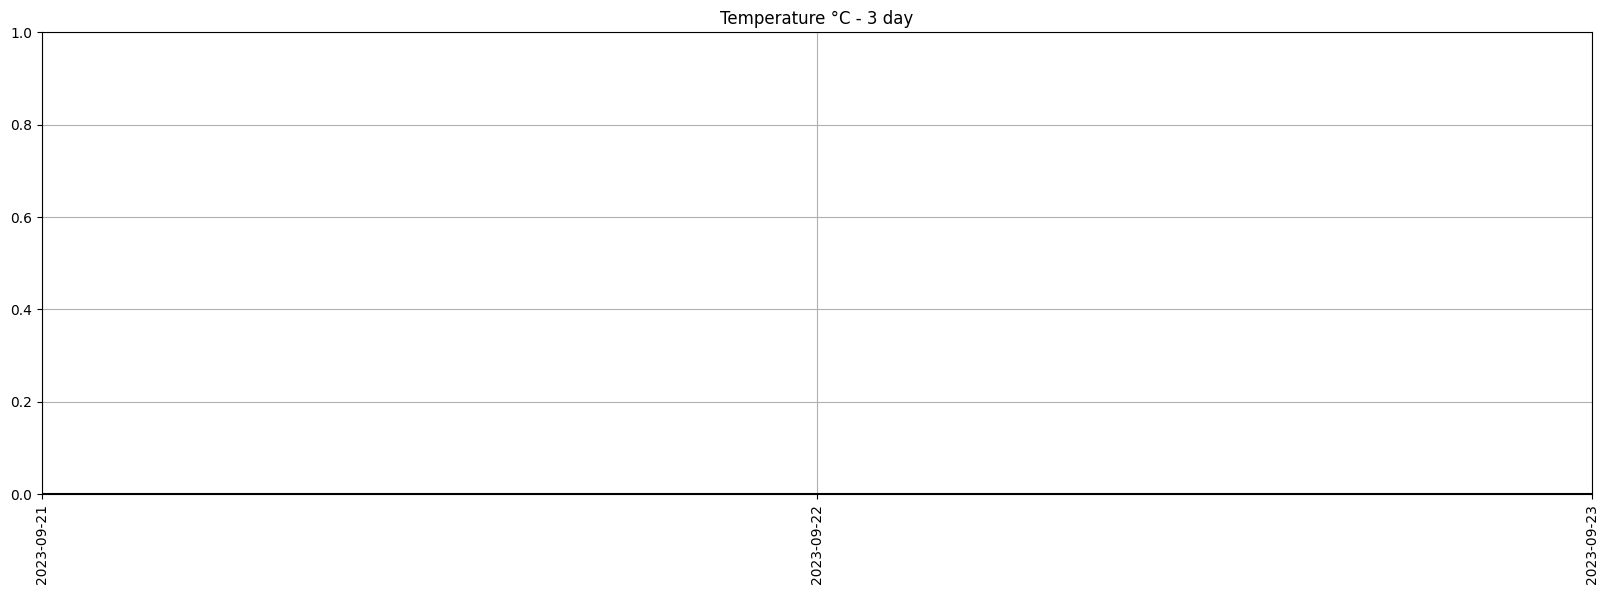

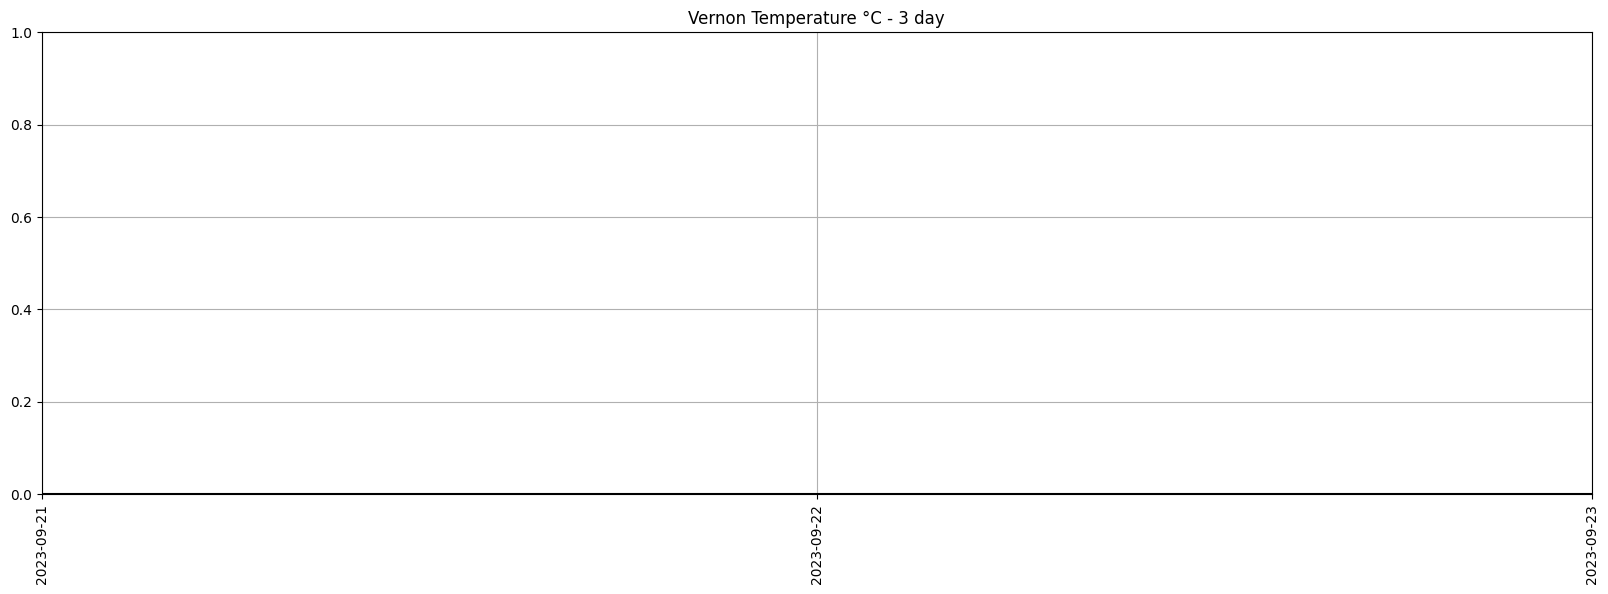

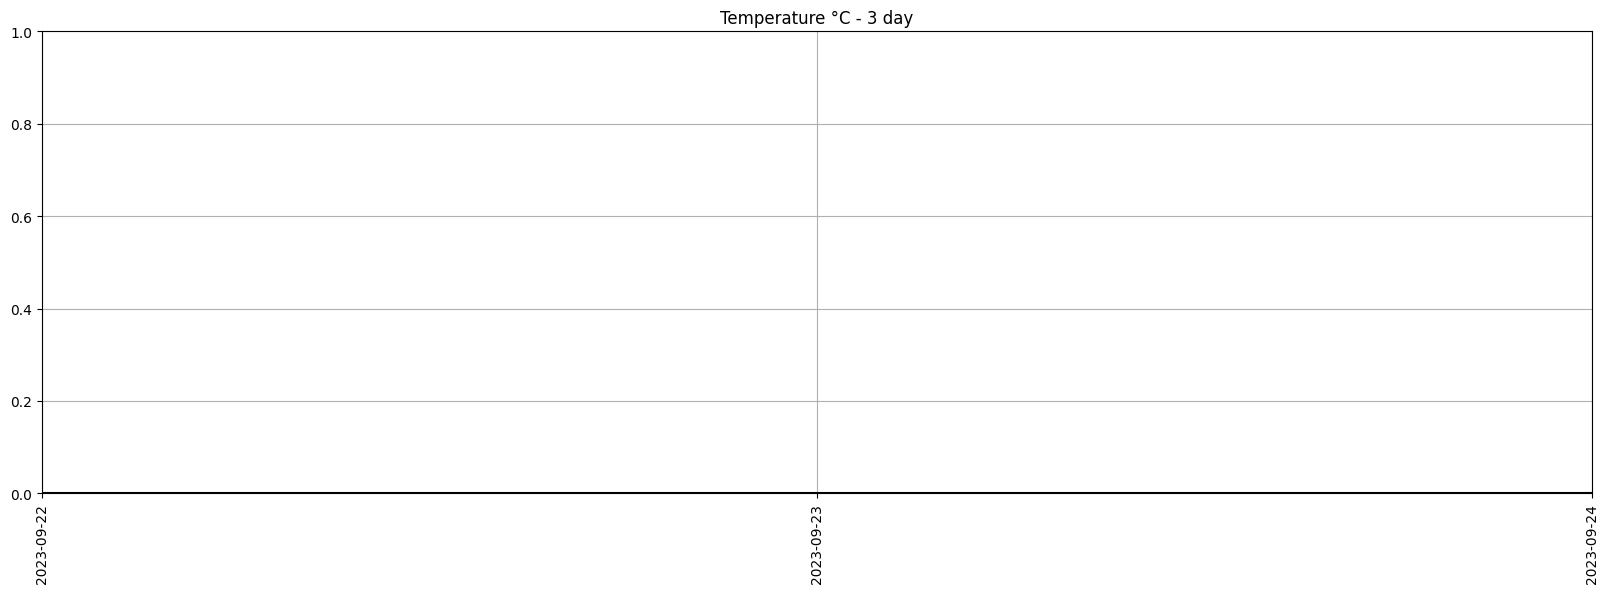

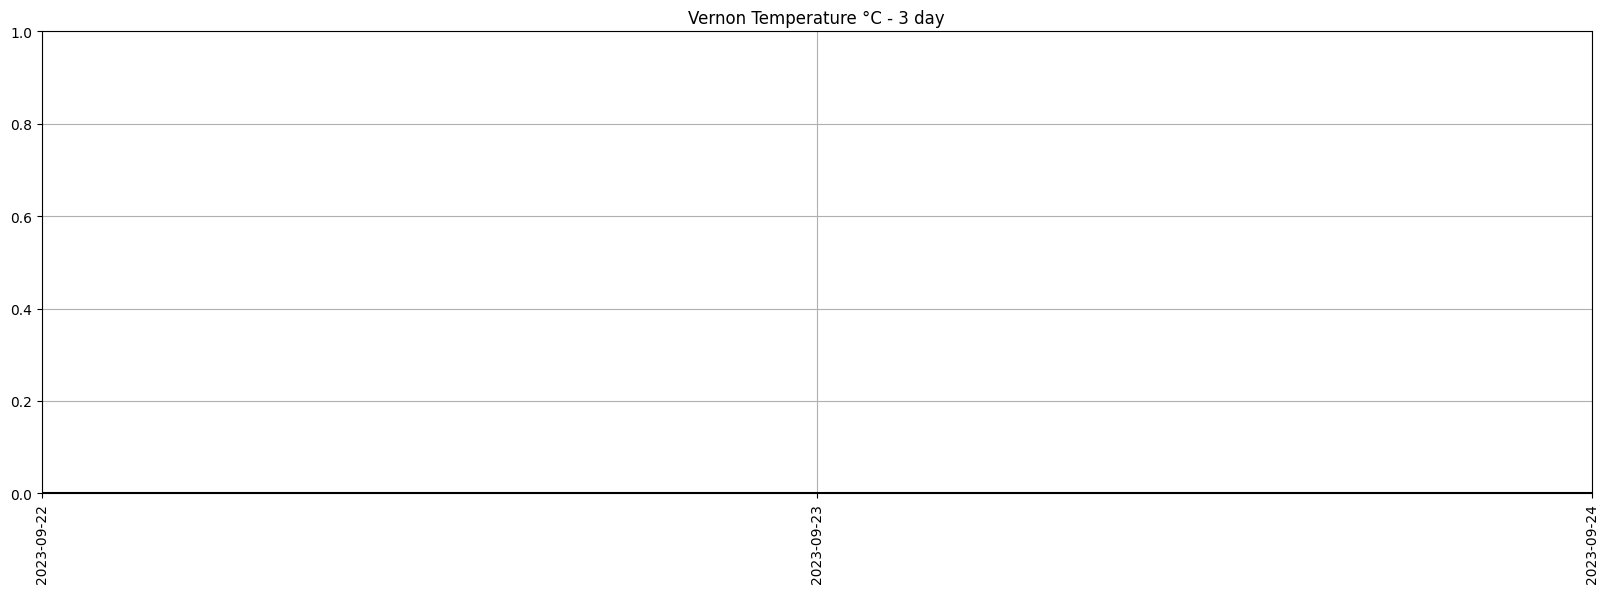

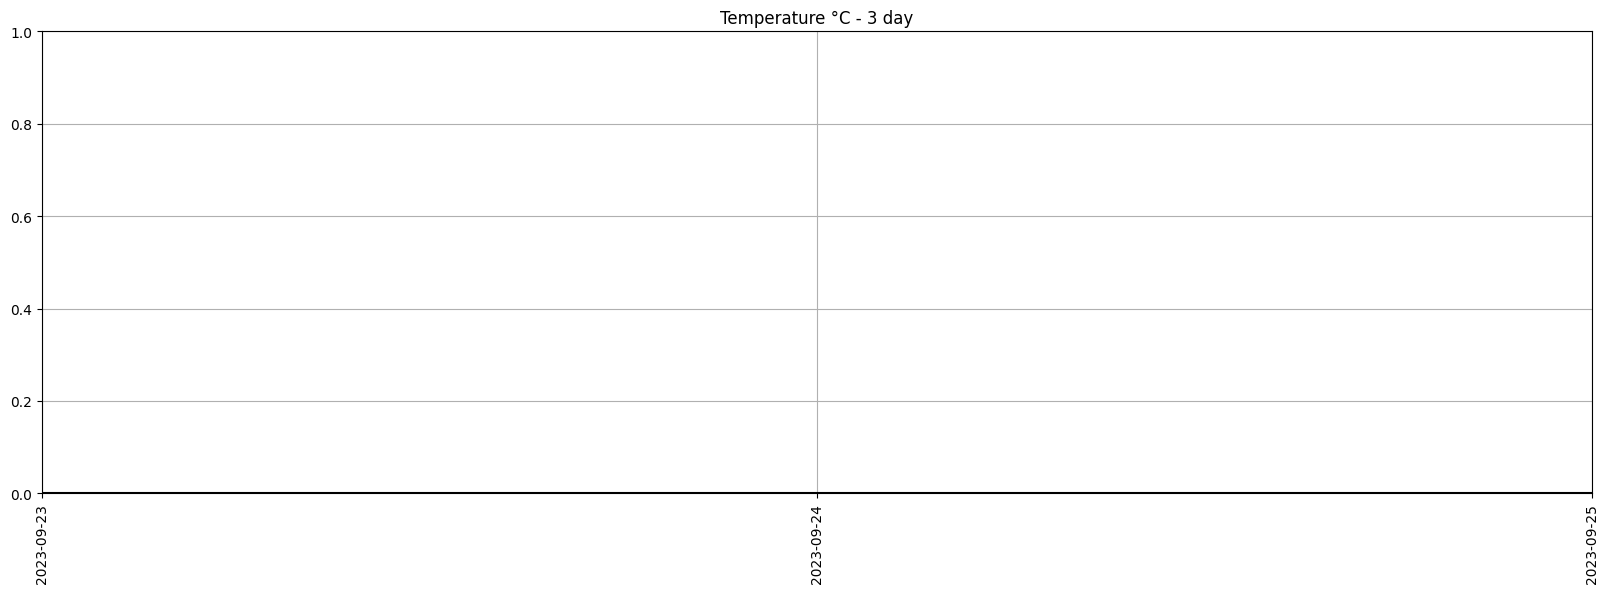

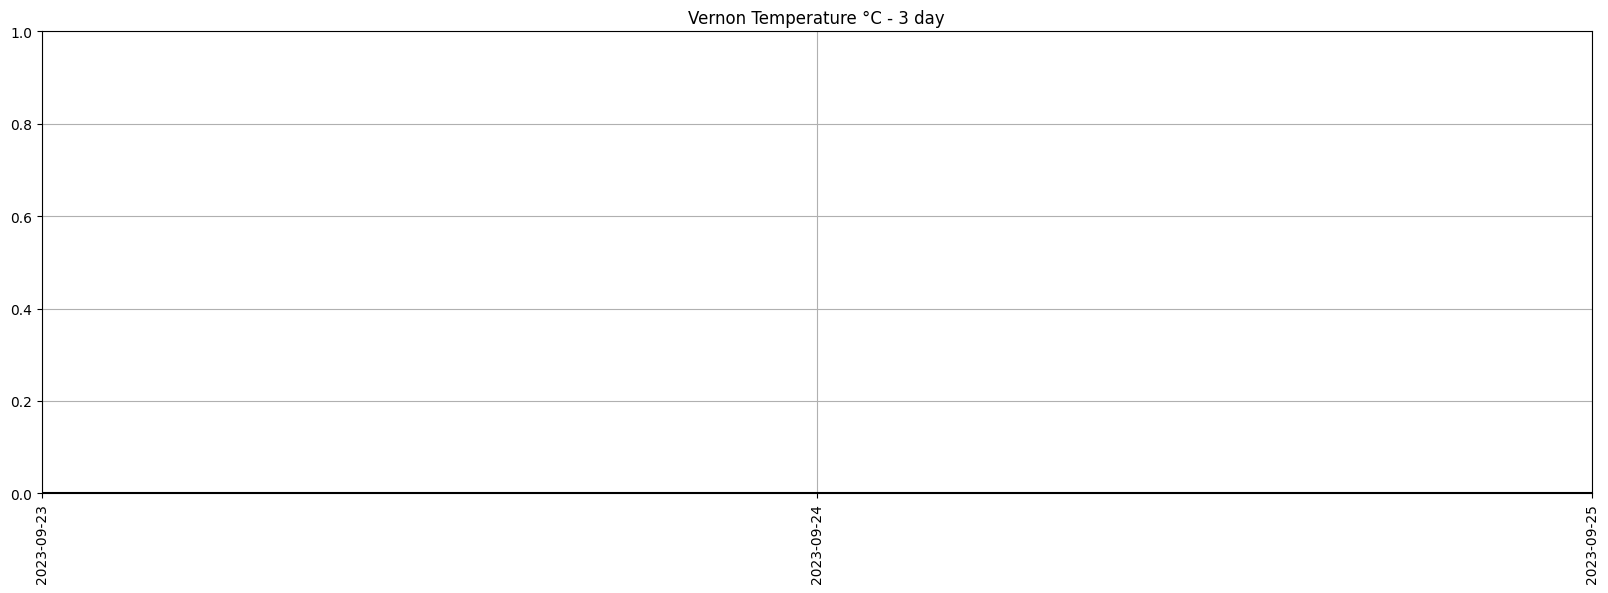

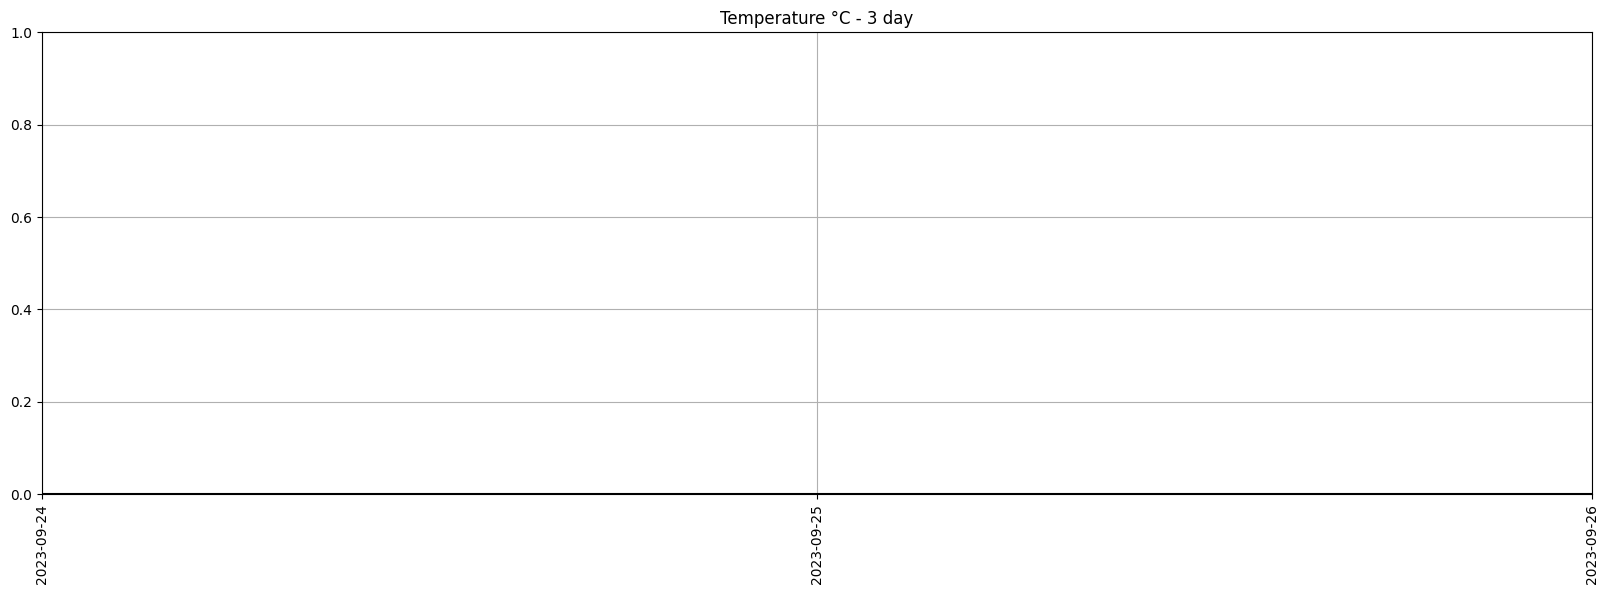

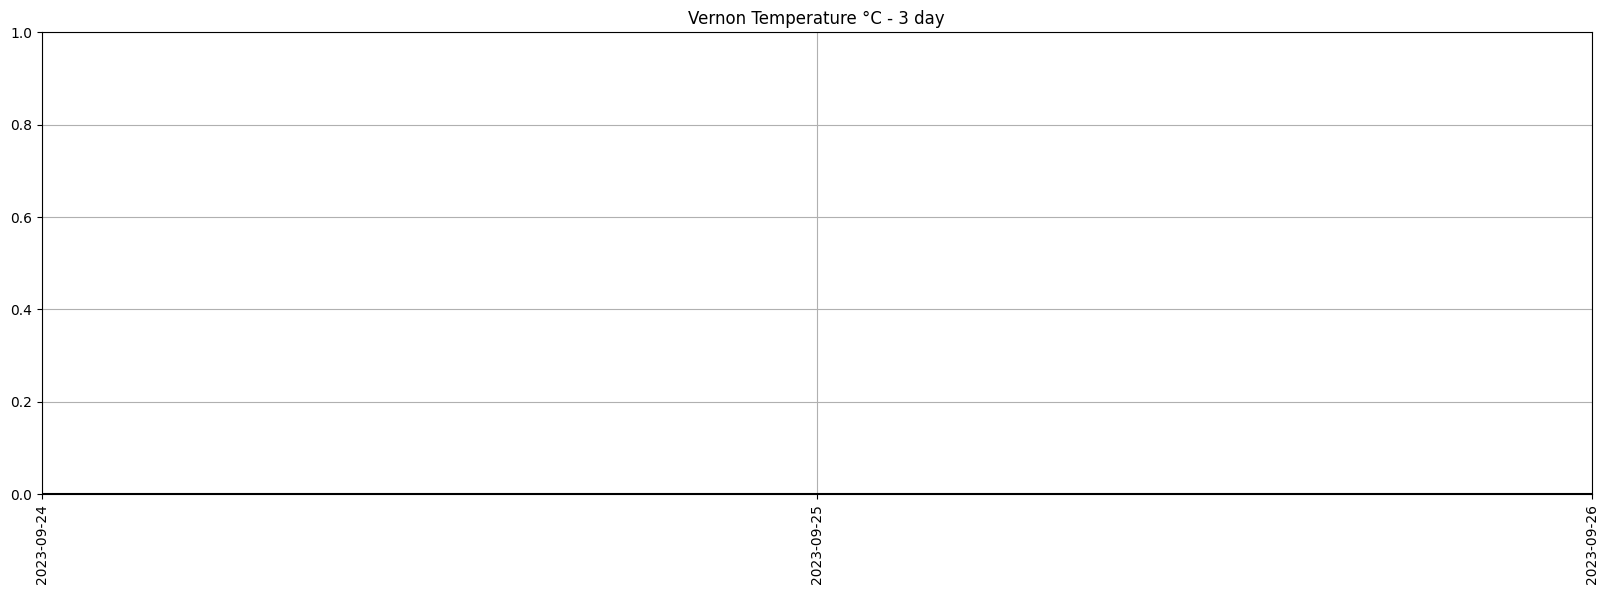

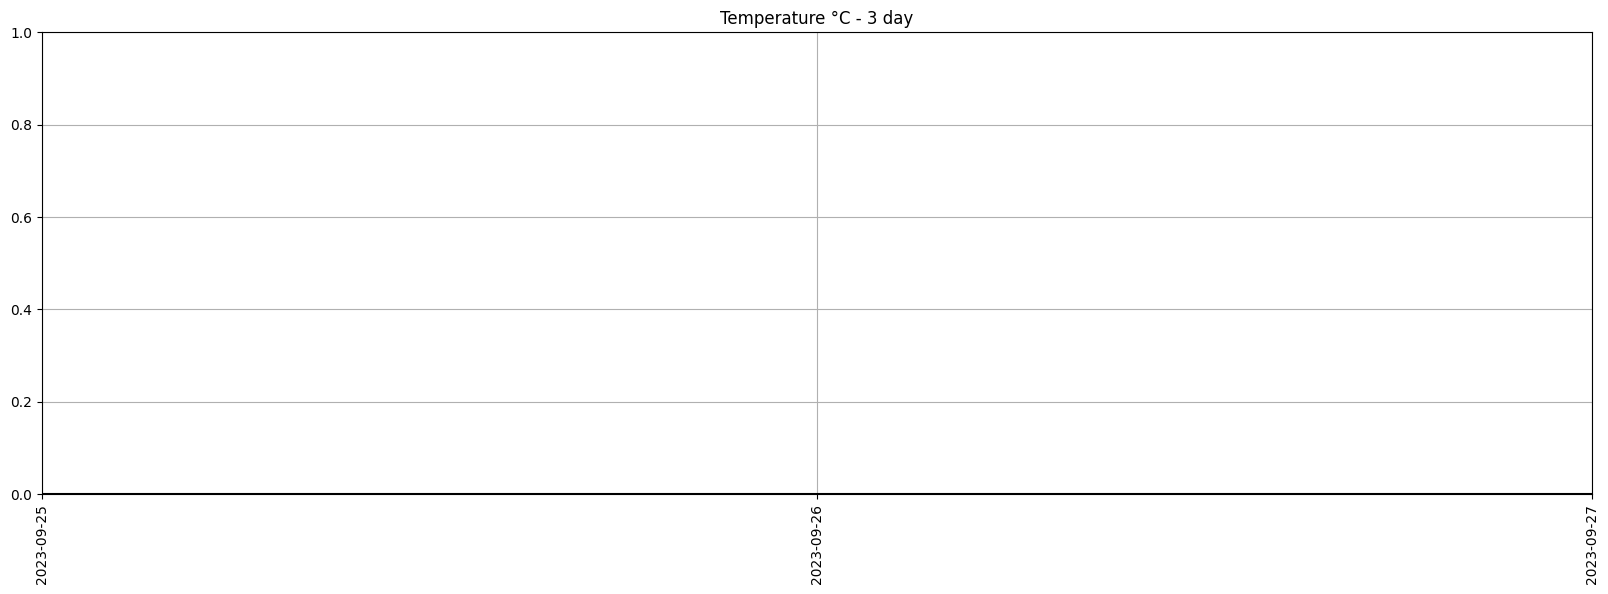

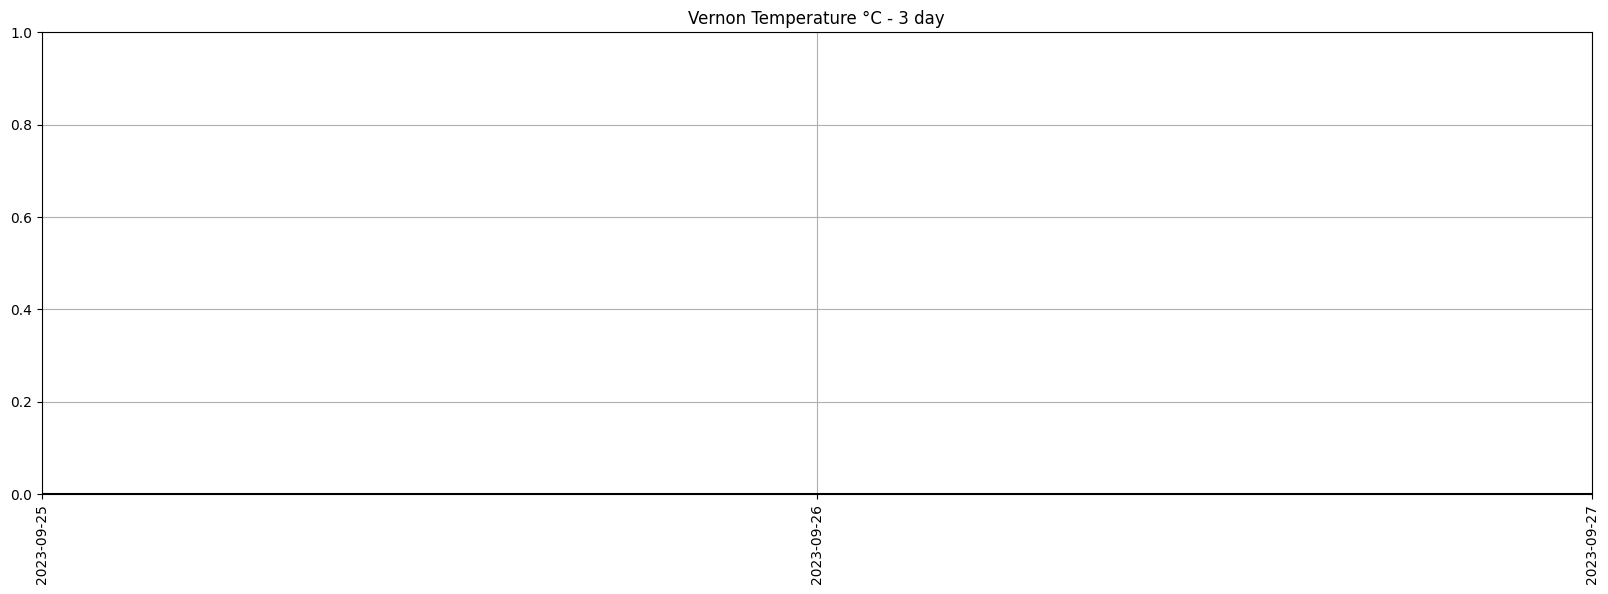

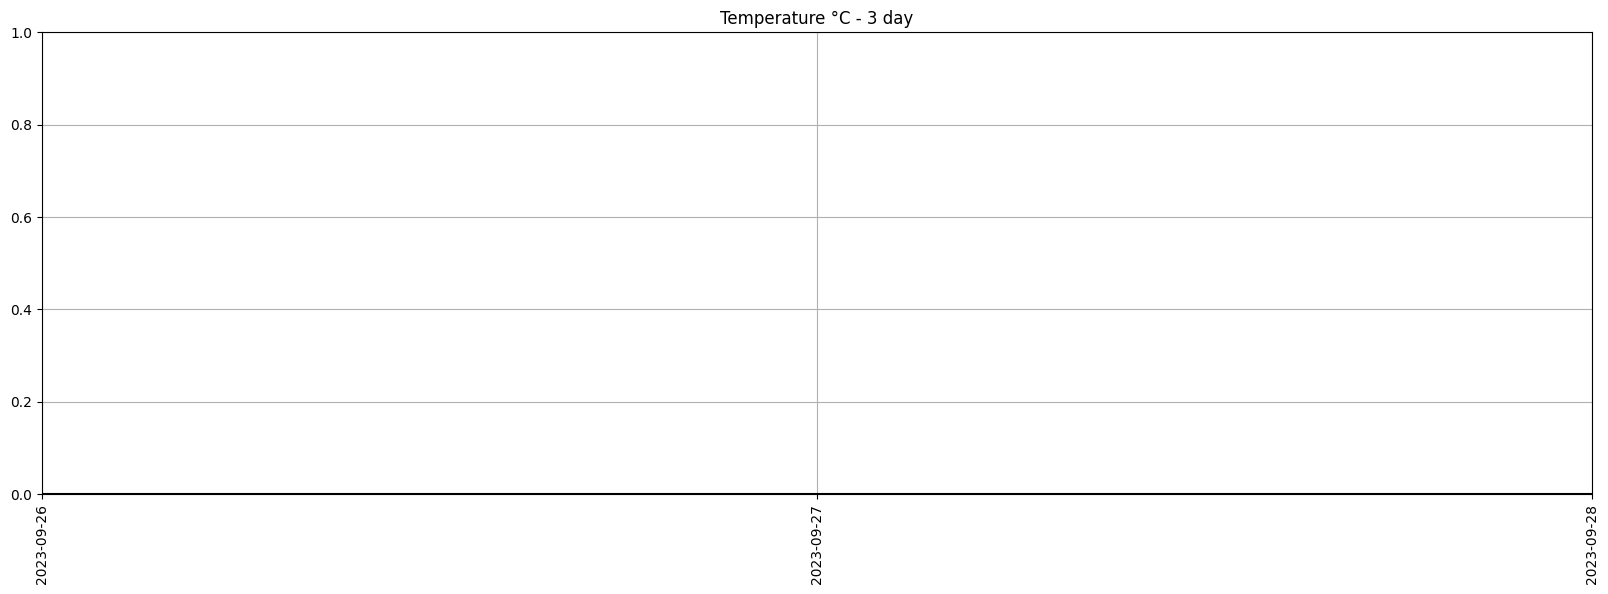

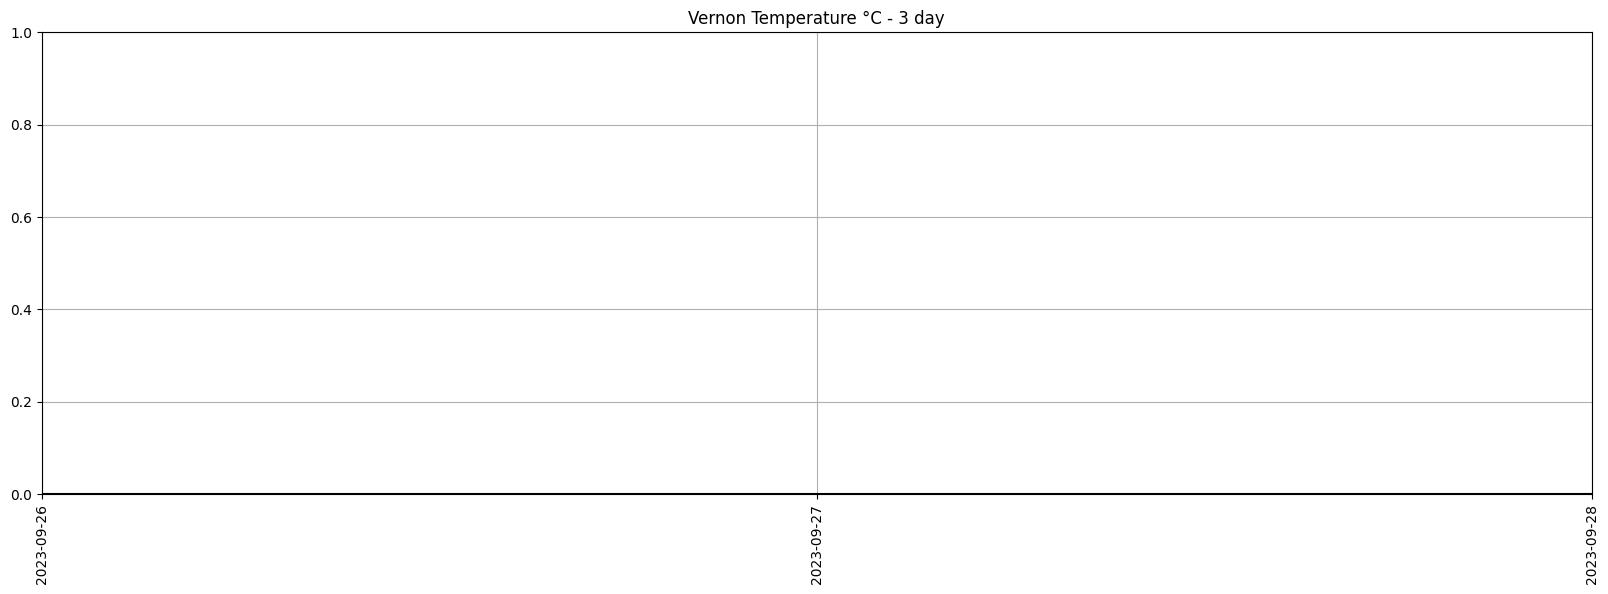

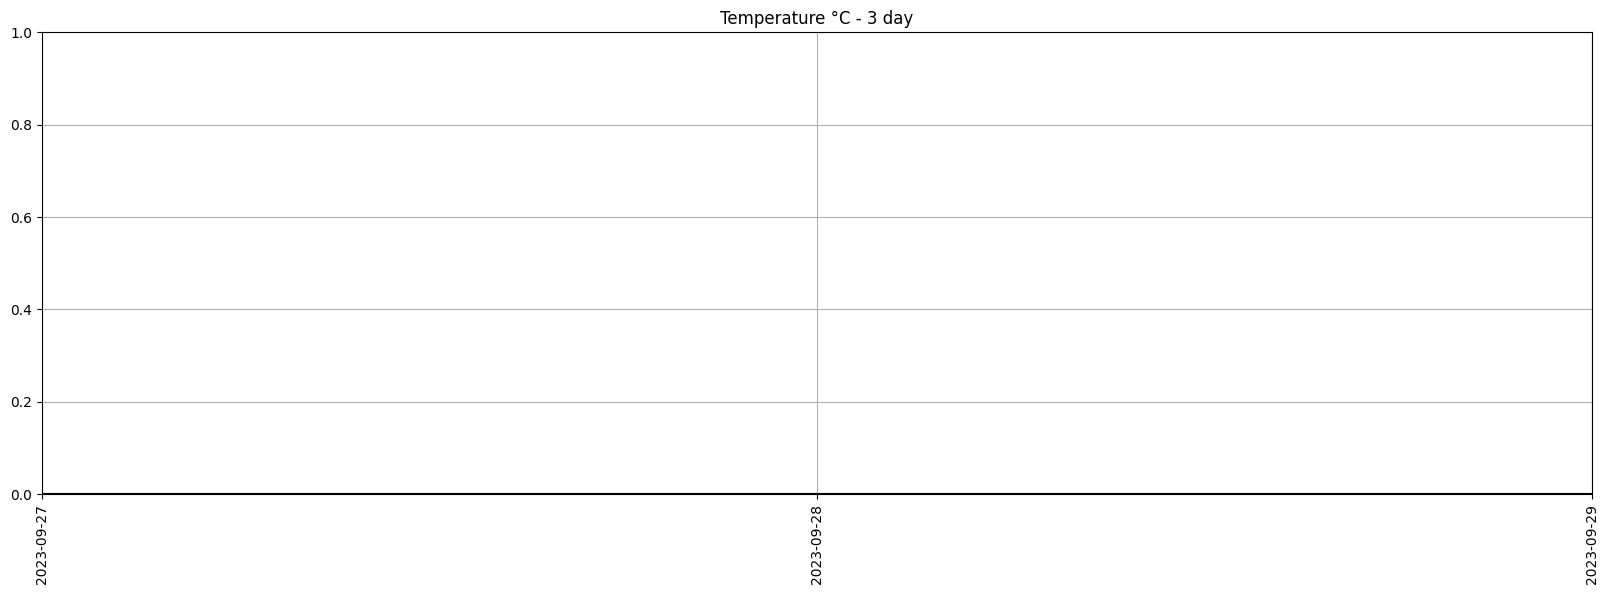

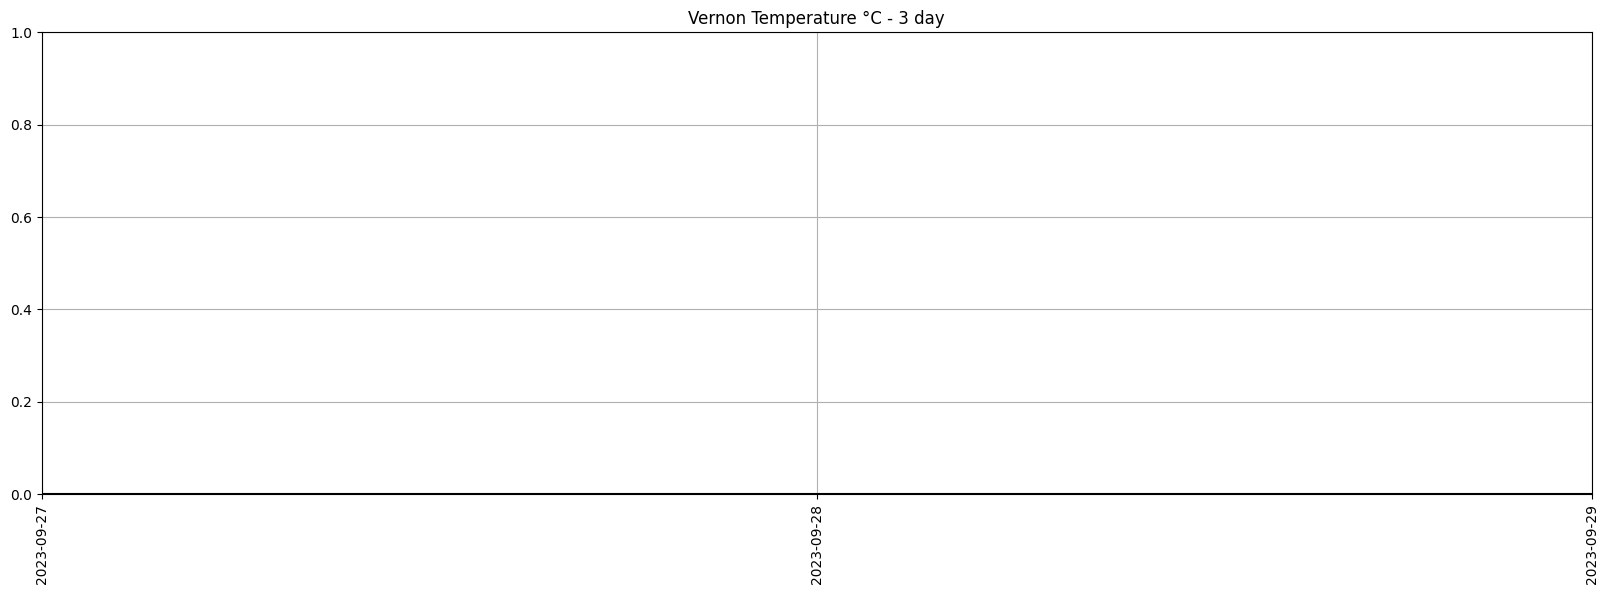

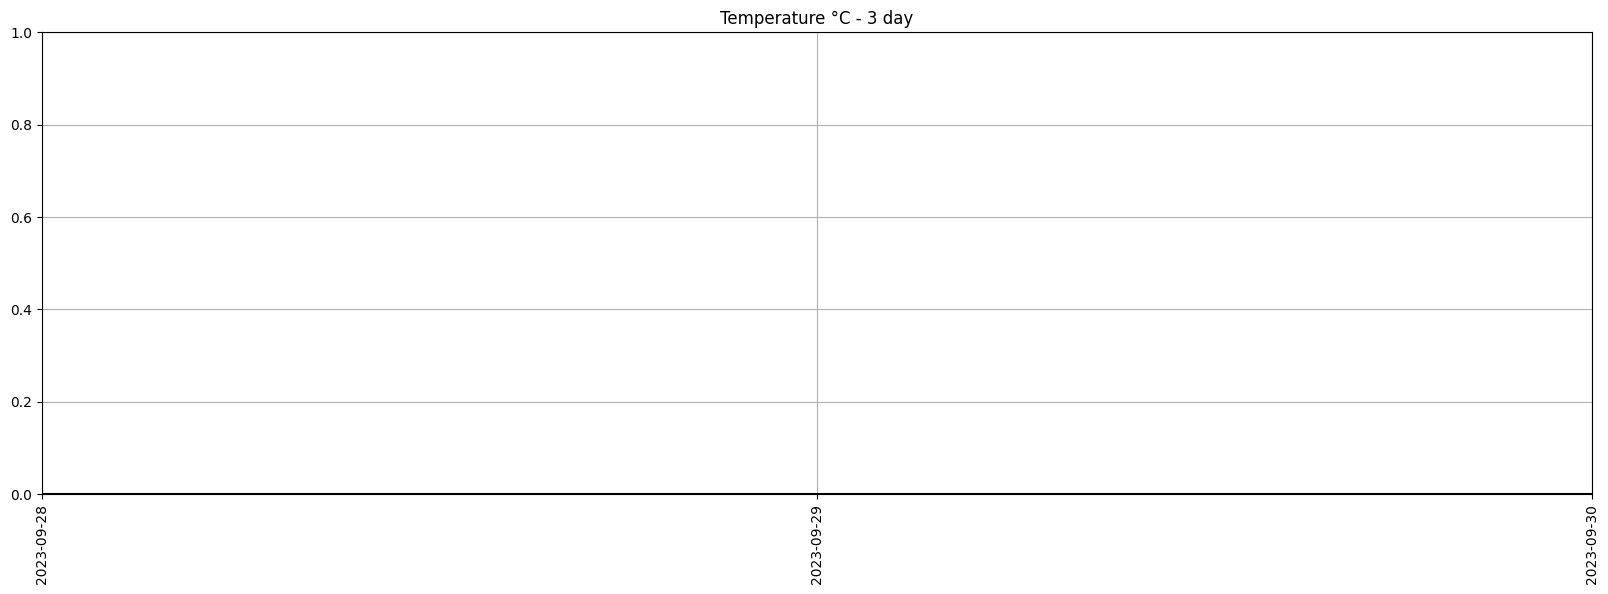

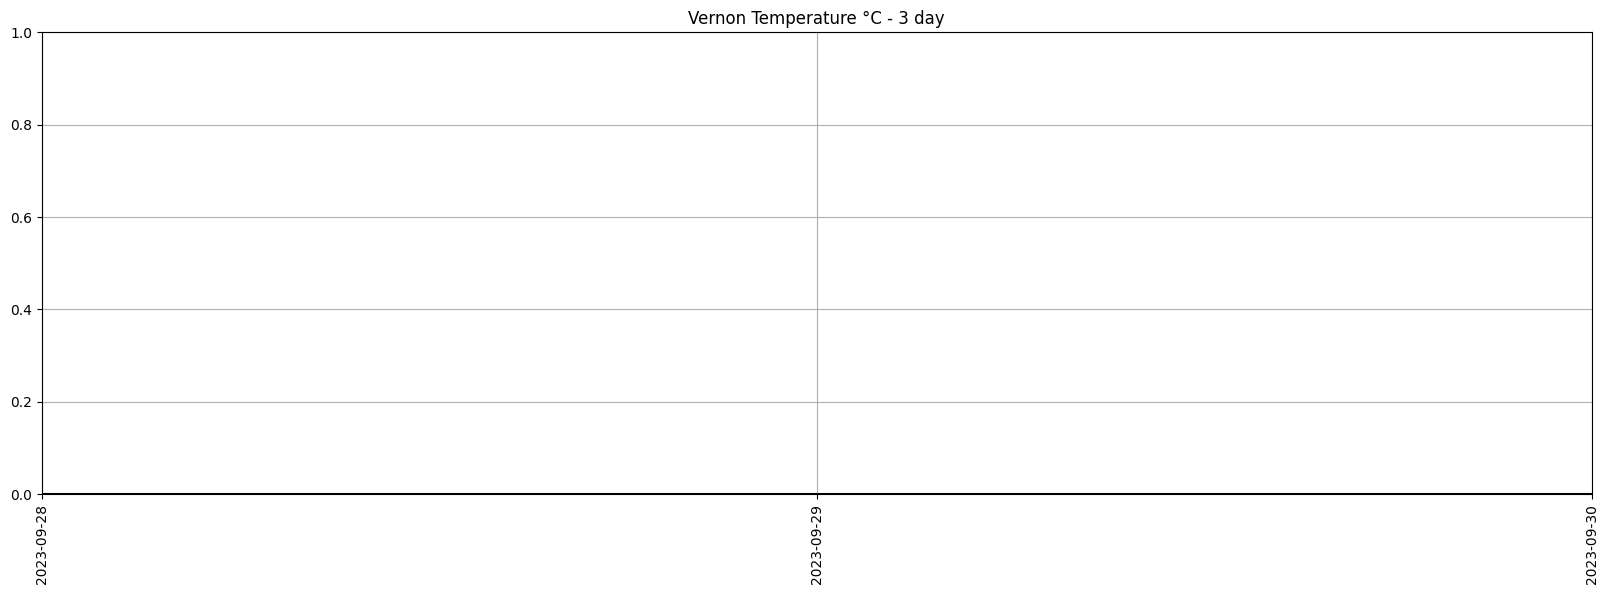

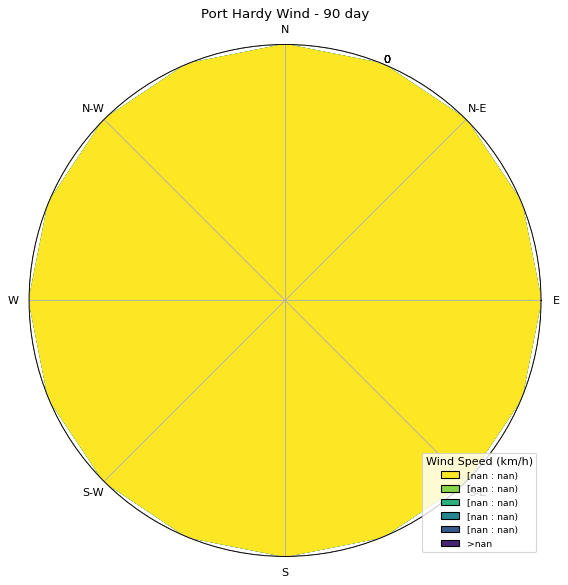

In [163]:
main()

In [23]:
storage_client = storage.Client()

In [25]:
weather_data = import_weather_data(storage_client)

In [26]:
weather_data.head()

,Date,Station,Time,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
0,2020-01-01,Port Hardy,AM,700,2856.0,-4.3,-5.8,89.0,3.56,250.0,87.044,297.7,308.6,298.3
1,2020-01-01,Port Hardy,AM,850,1301.0,3.4,1.9,90.0,5.19,250.0,59.264,289.7,304.8,290.6
2,2020-01-01,Port Hardy,PM,700,2857.0,-9.9,-17.9,52.0,1.34,280.0,64.820,291.5,295.7,291.7
3,2020-01-01,Port Hardy,PM,850,1328.0,0.4,-2.1,83.0,3.87,275.0,62.968,286.6,297.8,287.2
4,2020-01-01,Quillayute,AM,700,2969.0,-0.9,-0.9,100.0,5.14,255.0,100.008,301.5,317.2,302.4


In [33]:
start_date = datetime(2022, 10, 24)
end_date = datetime.today()
dates = []
for single_date in daterange(start_date, end_date):
    dates.append(single_date.date())

In [34]:
print(dates[:5])

[datetime.date(2022, 10, 24), datetime.date(2022, 10, 25), datetime.date(2022, 10, 26), datetime.date(2022, 10, 27), datetime.date(2022, 10, 28)]


In [35]:
plot_range = [3, 5, 10, 30, 90, 180]

In [36]:
locations = [{
        'name': "Vernon",
        'palette_order': [2, 4], # green
        'save_name': "vernon",
        'data': weather_data[weather_data['Station'] == "Vernon"]
    },
    {
        'name': "Port Hardy",
        'palette_order': [4, 6], # red
        'save_name': "porthardy",
        'data': weather_data[weather_data['Station'] == "Port Hardy"]
    },
    {
        'name': "Quillayute",
        'palette_order': [0, 2], # blue
        'save_name': "quillayute",
        'data': weather_data[weather_data['Station'] == "Quillayute"]
    }]

In [37]:
def plot_temps2(storage_client, location, weather_data, dates, plot_range):
    print("plotting temps")
    for d in dates:
        for r in plot_range:
            
            # Set figure details
            # ~~~~~~~~~~~~~~~~~~
            plt.figure(figsize=(20,6))
            plt.xlim([0, r -1])
            plt.grid()
            plt.axhline(0, color='black')
            plt.xticks(rotation = 'vertical')
            plt.title("Temperature °C - {} day".format(r))
            if r > 30:
                plt.xticks(np.arange(0, r+1, 7.0))

            # Set color palette for the graph
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            palette = sns.color_palette("Paired", n_colors=6)
            palette_order = [1, 0, 3, 2, 5, 4]
            palette = [palette[idx] for idx in palette_order]
            hue_order = [850, 700]


            # Create new df containing only data within plot range
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            mask = (weather_data['Date'] > str(d - timedelta(days=r))) & (weather_data['Date'] <= str(date))
            plot_data = weather_data.loc[mask]
            
            # Calculate IQR for column Temp
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            Q1 = plot_data['Temp'].quantile(0.10)
            Q3 = plot_data['Temp'].quantile(0.90)
            IQR = Q3 - Q1

            # Identify and remove outliers
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            threshold = 1.5
            outliers = plot_data[(plot_data['Temp'] < Q1 - threshold * IQR) | (plot_data['Temp'] > Q3 + threshold * IQR)]
            plot_data = plot_data.drop(outliers.index)
            
            if plot_data.dropna(subset=['Temp']):
                print("COULD NOT GENERATE GRAPH")
                print("Location: {}".format(location['name']))
                print("Date: {}".format(d))
                print("Plot Range: {}".format(r))
                print("Data: {}\n".format(plot_data))
                continue

            # Plot graph
            # ~~~~~~~~~~
            try:
                g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=plot_data, palette=palette[location['palette_order'][0]: location['palette_order'][1]], hue_order=hue_order)
            except Exception as e:
                print(e)
                print(plot_data)

            # Rename legend with detailed labels
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            l = plt.legend()
            labels = ['850', '700']
            for x, label in enumerate(labels):
                l.get_texts()[x].set_text(label)
                
            # Define save details
            # ~~~~~~~~~~~~~~~~~~~
            save_name = '{}_temp'.format(location['save_name'])
            save_loc = "./figures/temp/{}".format(d.strftime("%Y-%m-%d"))
            if not os.path.isdir(save_loc):
                os.makedirs(save_loc)
                
            # Publish graph to Google Cloud
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            bucket_name = 'weather_aurorabc'
            bucket = storage_client.bucket(bucket_name)

            buff = io.BytesIO()
            plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

            blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(d.strftime("%Y-%m-%d"), save_name, r, d.strftime("%Y-%m-%d"))
            blob = bucket.blob(blob_name)
            blob.upload_from_string(buff.getvalue(), content_type='image/png')
            plt.close()
            del buff


on 0: plotting temps                                                                                                    
on 0: plotting temps                                                                                                    
on 0: plotting temps                                                                                                    
on 1: plotting temps                                                                                                    
on 1: plotting temps                                                                                                    
on 1: plotting temps                                                                                                    
on 2: plotting temps                                                                                                    
on 2: plotting temps                                                                                                    
on 2: plotting temps            

on 22: plotting temps                                                                                                   
on 22: plotting temps                                                                                                   
on 23: plotting temps                                                                                                   
on 23: plotting temps                                                                                                   
on 23: plotting temps                                                                                                   
on 24: plotting temps                                                                                                   
on 24: plotting temps                                                                                                   
on 24: plotting temps                                                                                                   
on 25: plotting temps           

on 44: plotting temps                                                                                                   
on 45: plotting temps                                                                                                   
on 45: plotting temps                                                                                                   
on 45: plotting temps                                                                                                   
on 46: plotting temps                                                                                                   
on 46: plotting temps                                                                                                   
on 46: plotting temps                                                                                                   
on 47: plotting temps                                                                                                   
on 47: plotting temps           

on 67: plotting temps                                                                                                   
on 67: plotting temps                                                                                                   
on 67: plotting temps                                                                                                   
on 68: plotting temps                                                                                                   
on 68: plotting temps                                                                                                   
on 68: plotting temps                                                                                                   
on 69: plotting temps                                                                                                   
on 69: plotting temps                                                                                                   
on 69: plotting temps           

on 89: plotting temps                                                                                                   
on 89: plotting temps                                                                                                   
on 90: plotting temps                                                                                                   
on 90: plotting temps                                                                                                   
on 90: plotting temps                                                                                                   
on 91: plotting temps                                                                                                   
on 91: plotting temps                                                                                                   
on 91: plotting temps                                                                                                   
on 92: plotting temps           

on 111: plotting temps                                                                                                  
on 112: plotting temps                                                                                                  
on 112: plotting temps                                                                                                  
on 112: plotting temps                                                                                                  
on 113: plotting temps                                                                                                  
on 113: plotting temps                                                                                                  
on 113: plotting temps                                                                                                  
on 114: plotting temps                                                                                                  
on 114: plotting temps          

on 134: plotting temps                                                                                                  
on 134: plotting temps                                                                                                  
on 134: plotting temps                                                                                                  
on 135: plotting temps                                                                                                  
on 135: plotting temps                                                                                                  
on 135: plotting temps                                                                                                  
on 136: plotting temps                                                                                                  
on 136: plotting temps                                                                                                  
on 136: plotting temps          

on 156: plotting temps                                                                                                  
on 156: plotting temps                                                                                                  
on 157: plotting temps                                                                                                  
on 157: plotting temps                                                                                                  
on 157: plotting temps                                                                                                  
on 158: plotting temps                                                                                                  
on 158: plotting temps                                                                                                  
on 158: plotting temps                                                                                                  
on 159: plotting temps          

on 178: plotting temps                                                                                                  
on 179: plotting temps                                                                                                  
on 179: plotting temps                                                                                                  
on 179: plotting temps                                                                                                  
on 180: plotting temps                                                                                                  
on 180: plotting temps                                                                                                  
on 180: plotting temps                                                                                                  
on 181: plotting temps                                                                                                  
on 181: plotting temps          

on 201: plotting temps                                                                                                  
on 201: plotting temps                                                                                                  
on 201: plotting temps                                                                                                  
on 202: plotting temps                                                                                                  
on 202: plotting temps                                                                                                  
on 202: plotting temps                                                                                                  
on 203: plotting temps                                                                                                  
on 203: plotting temps                                                                                                  
on 203: plotting temps          

on 223: plotting temps                                                                                                  
on 223: plotting temps                                                                                                  
on 224: plotting temps                                                                                                  
on 224: plotting temps                                                                                                  
on 224: plotting temps                                                                                                  
on 225: plotting temps                                                                                                  
on 225: plotting temps                                                                                                  
on 225: plotting temps                                                                                                  
on 226: plotting temps          

on 245: plotting temps                                                                                                  
on 246: plotting temps                                                                                                  
on 246: plotting temps                                                                                                  
on 246: plotting temps                                                                                                  
on 247: plotting temps                                                                                                  
on 247: plotting temps                                                                                                  
on 247: plotting temps                                                                                                  
on 248: plotting temps                                                                                                  
on 248: plotting temps          

on 266: plotting temps                                                                                                  
on 266: plotting temps                                                                                                  
on 266: plotting temps                                                                                                  
on 266: COULD NOT GENERATE GRAPH                                                                                        
on 266: Location: Quillayute                                                                                            
on 266: Date: 2023-07-17                                                                                                
on 266: Plot Range: 3                                                                                                   
on 266: Data: Empty DataFrame                                                                                           
        Columns: [Date, Station,

on 281: plotting temps                                                                                                  
on 282: plotting temps                                                                                                  
on 282: plotting temps                                                                                                  
on 282: plotting temps                                                                                                  
on 283: plotting temps                                                                                                  
on 283: plotting temps                                                                                                  
on 283: plotting temps                                                                                                  
on 284: plotting temps                                                                                                  
on 284: plotting temps          

on 304: plotting temps                                                                                                  
on 304: plotting temps                                                                                                  
on 304: plotting temps                                                                                                  
on 305: plotting temps                                                                                                  
on 305: plotting temps                                                                                                  
on 305: plotting temps                                                                                                  
on 306: plotting temps                                                                                                  
on 306: plotting temps                                                                                                  
on 306: plotting temps          

on 326: plotting temps                                                                                                  
on 326: plotting temps                                                                                                  
on 327: plotting temps                                                                                                  
on 327: plotting temps                                                                                                  
on 327: plotting temps                                                                                                  
on 328: plotting temps                                                                                                  
on 328: plotting temps                                                                                                  
on 328: plotting temps                                                                                                  
on 329: plotting temps          

on 348: plotting temps                                                                                                  
on 349: plotting temps                                                                                                  
on 349: plotting temps                                                                                                  
on 349: plotting temps                                                                                                  
on 350: plotting temps                                                                                                  
on 350: plotting temps                                                                                                  
on 350: plotting temps                                                                                                  
on 351: plotting temps                                                                                                  
on 351: plotting temps          

on 371: plotting temps                                                                                                  
on 371: plotting temps                                                                                                  
on 371: plotting temps                                                                                                  
on 372: plotting temps                                                                                                  
on 372: plotting temps                                                                                                  
on 372: plotting temps                                                                                                  
on 373: plotting temps                                                                                                  
on 373: plotting temps                                                                                                  
on 373: plotting temps          

on 391: plotting temps                                                                                                  
on 391: COULD NOT GENERATE GRAPH                                                                                        
on 391: Location: Port Hardy                                                                                            
on 391: Date: 2023-11-19                                                                                                
on 391: Plot Range: 3                                                                                                   
on 391: Data: Empty DataFrame                                                                                           
        Columns: [Date, Station, Time, Pressure, Height, Temp, DewPoint, Relative_Humidity, Mean_Mixed_Layer, Wind_Direction, Wind_Speed, Potential_Temp, Equivalent_Potential_Temp, Virtual_Potential_Temp]
        Index: []
on 391: plotting temps                             

on 393: plotting temps                                                                                                  
on 393: COULD NOT GENERATE GRAPH                                                                                        
on 393: Location: Quillayute                                                                                            
on 393: Date: 2023-11-21                                                                                                
on 393: Plot Range: 3                                                                                                   
on 393: Data: Empty DataFrame                                                                                           
        Columns: [Date, Station, Time, Pressure, Height, Temp, DewPoint, Relative_Humidity, Mean_Mixed_Layer, Wind_Direction, Wind_Speed, Potential_Temp, Equivalent_Potential_Temp, Virtual_Potential_Temp]
        Index: []
on 393: COULD NOT GENERATE GRAPH                   

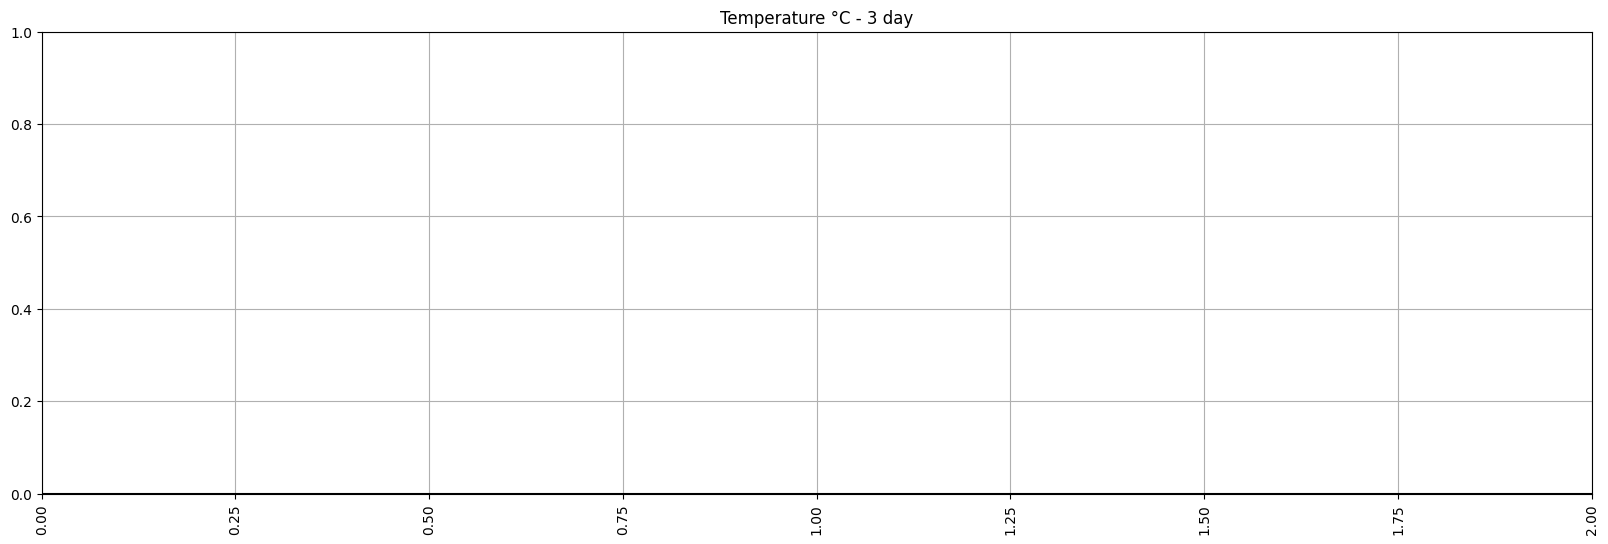

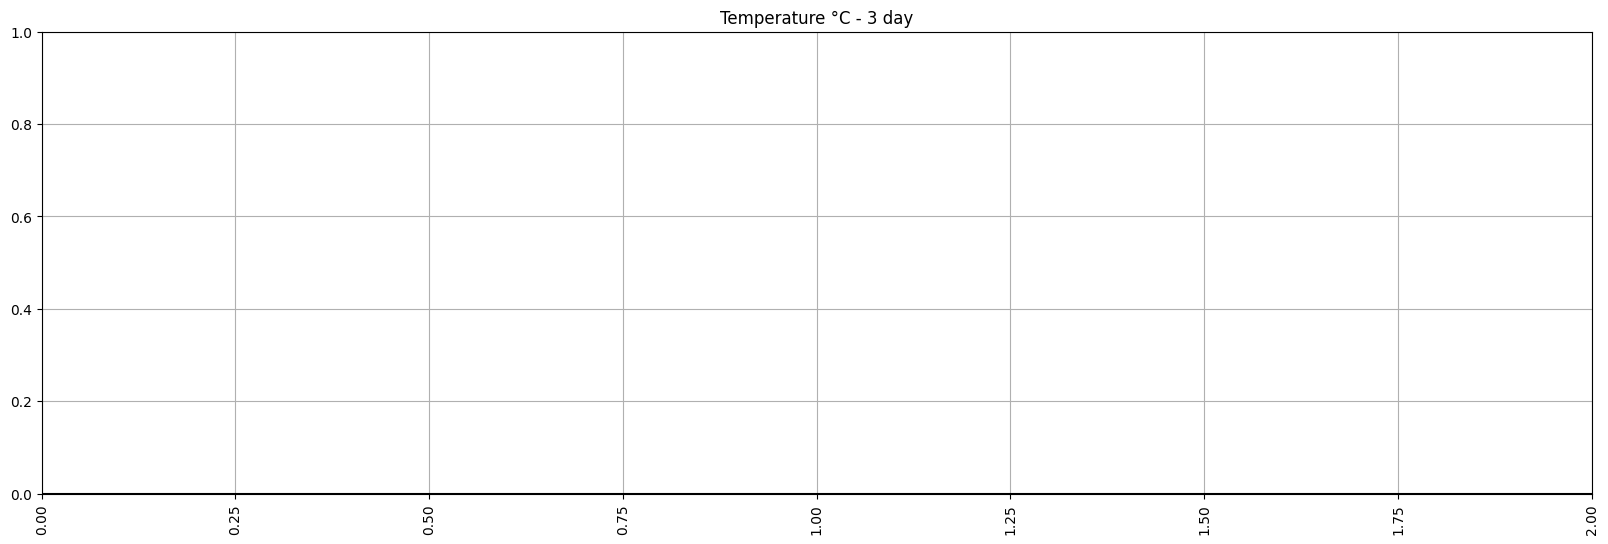

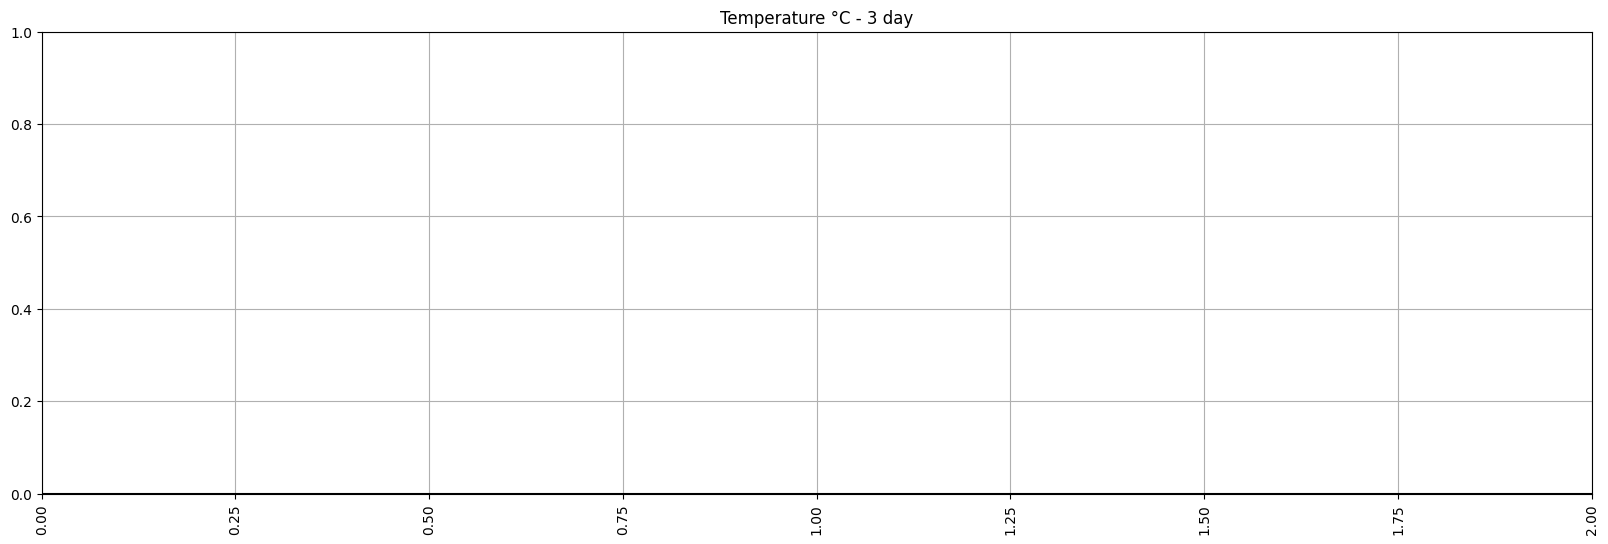

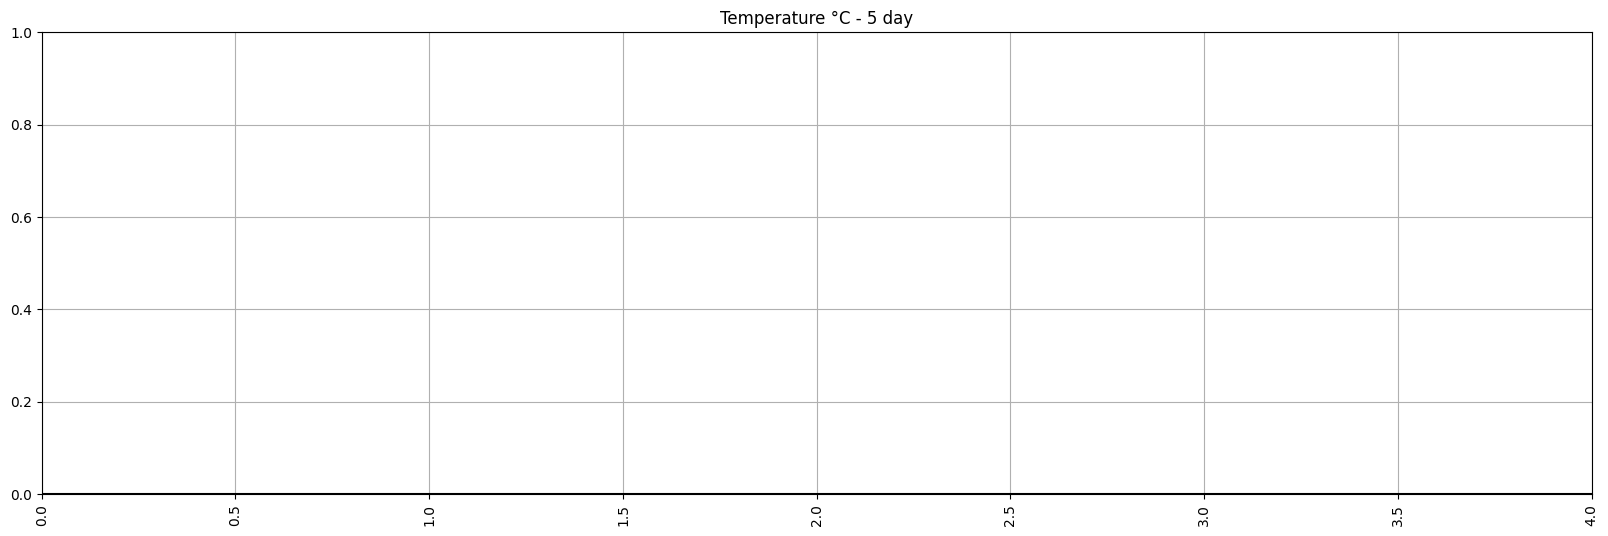

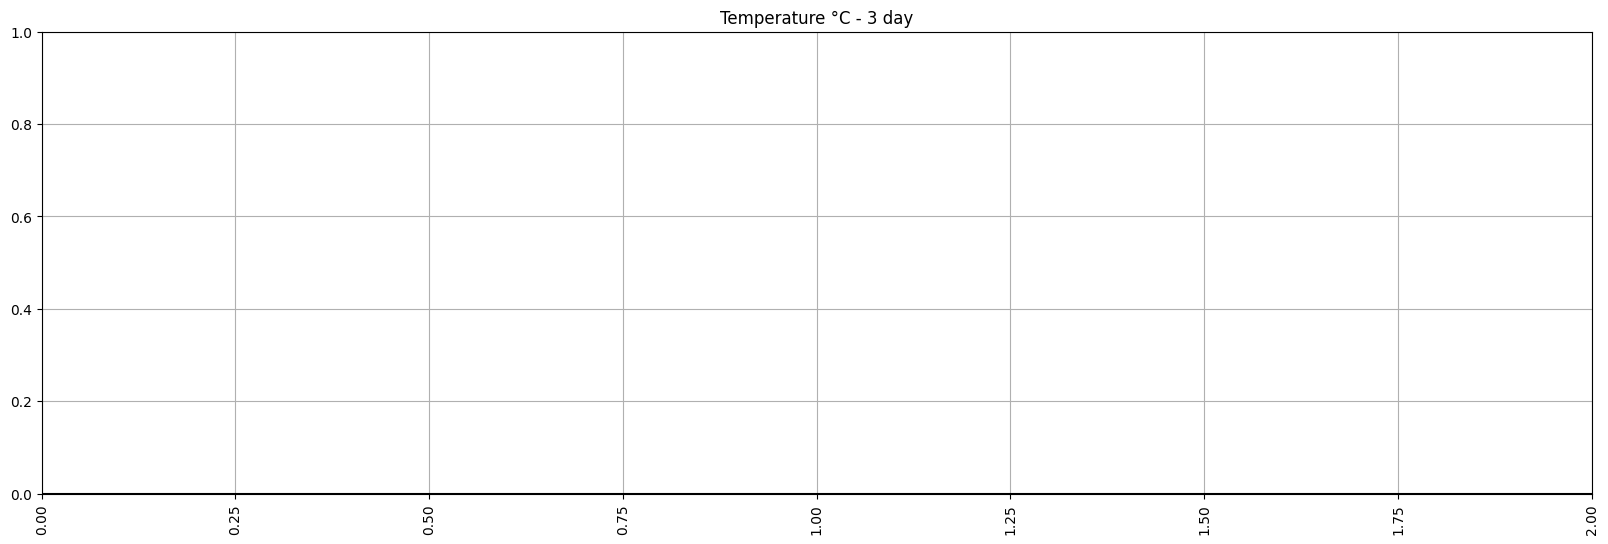

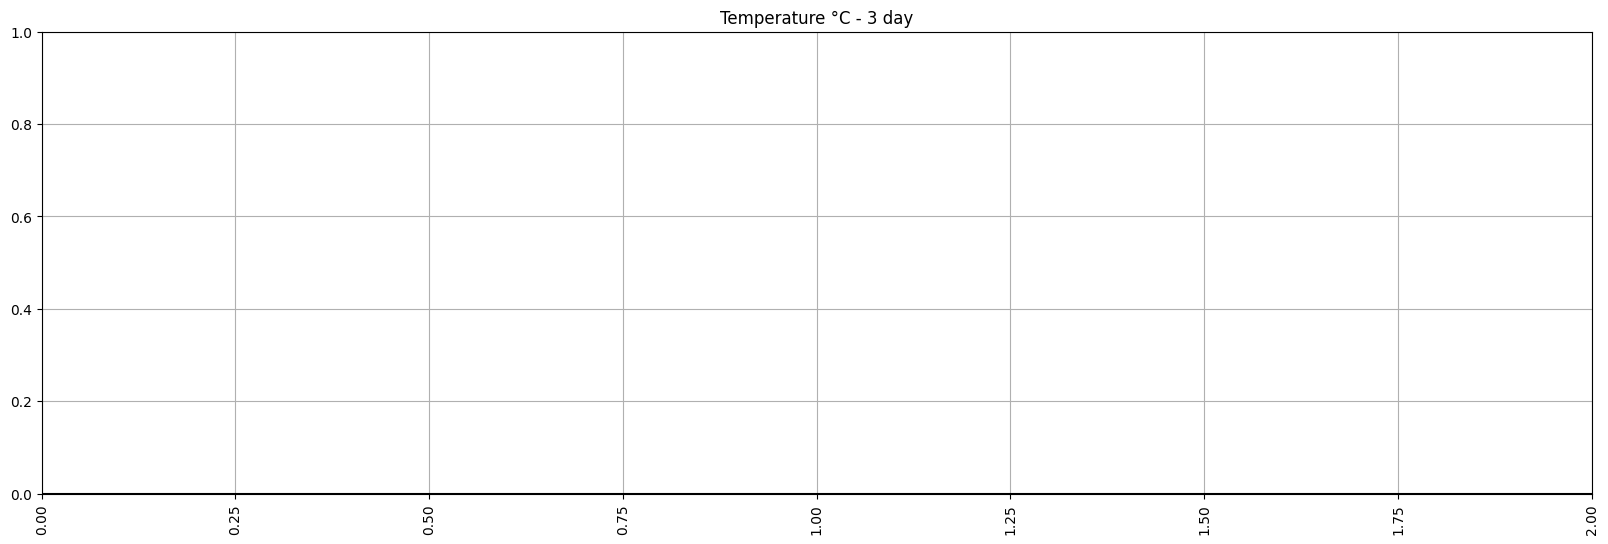

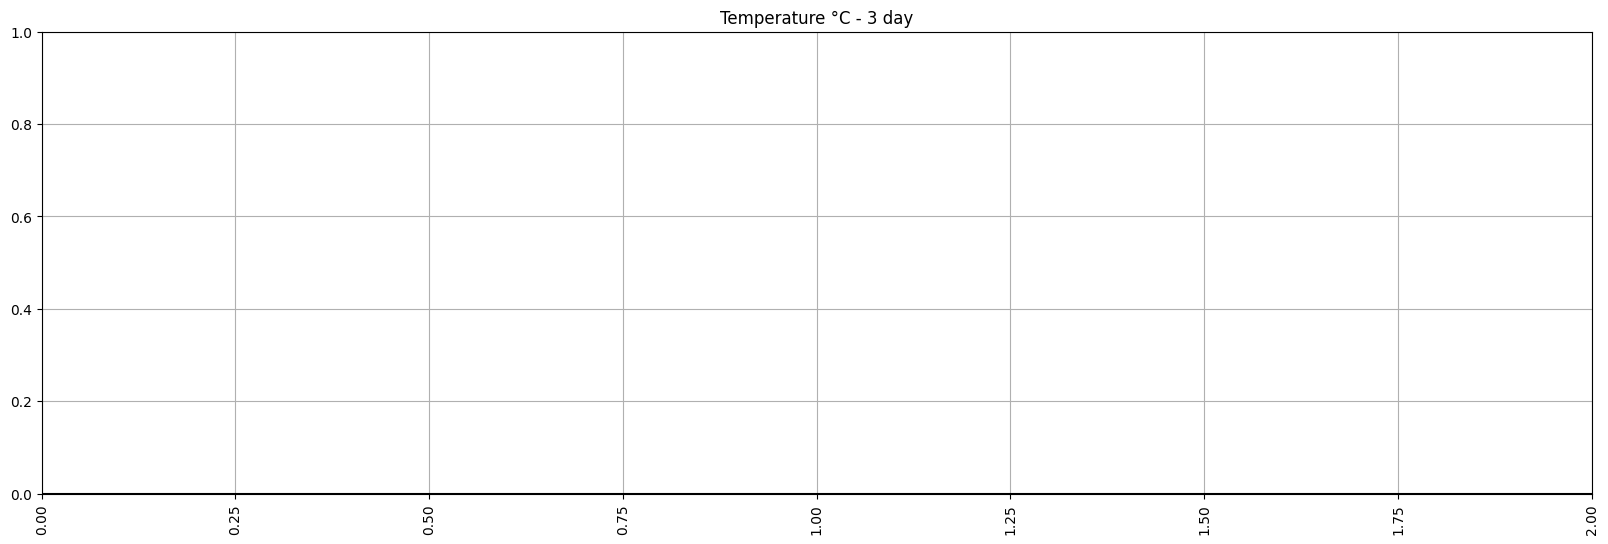

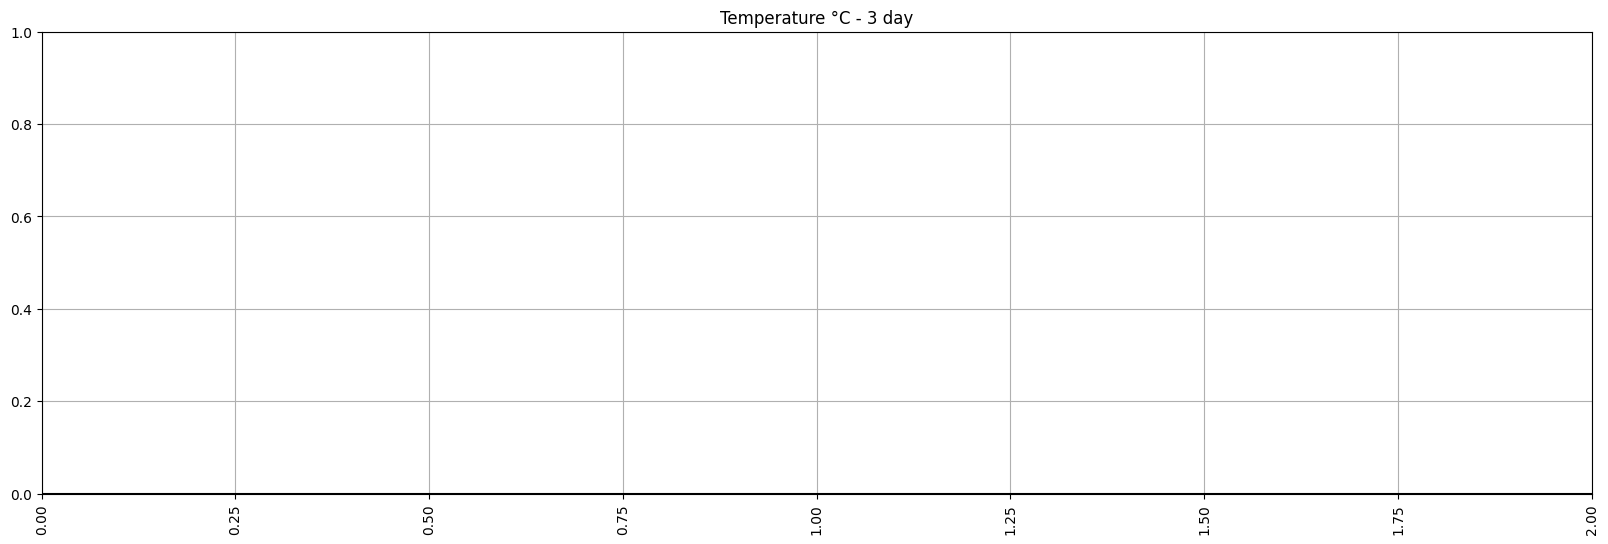

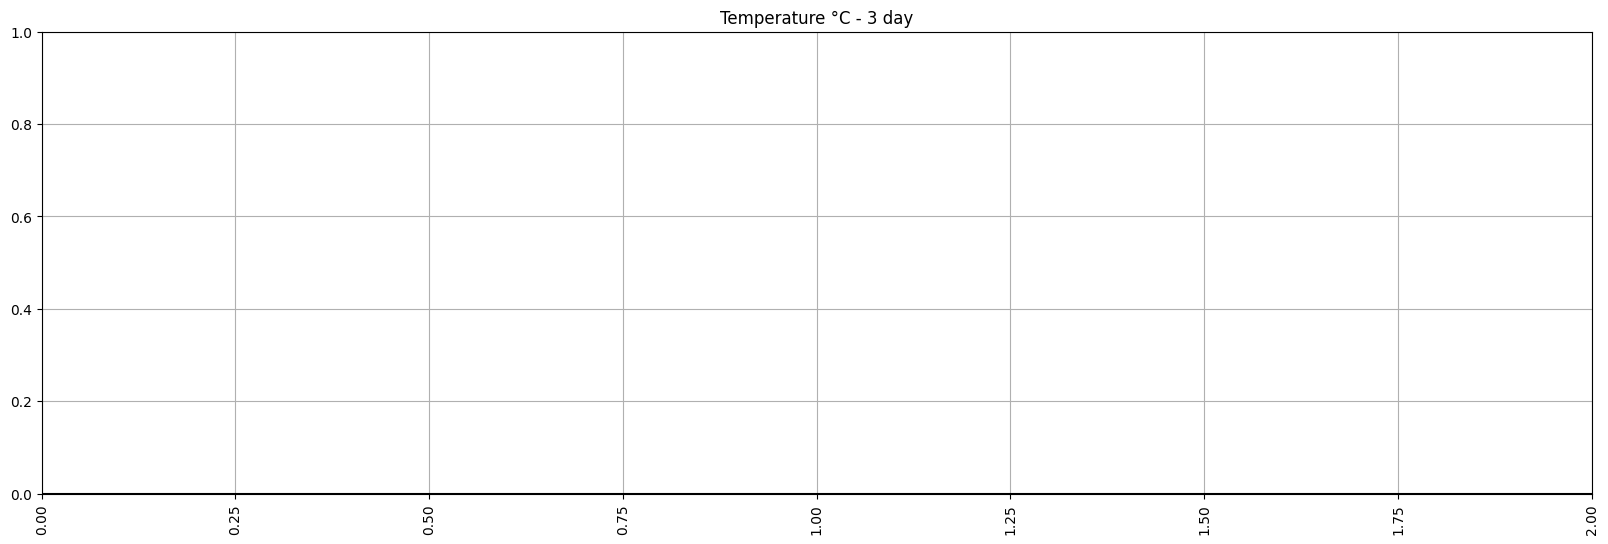

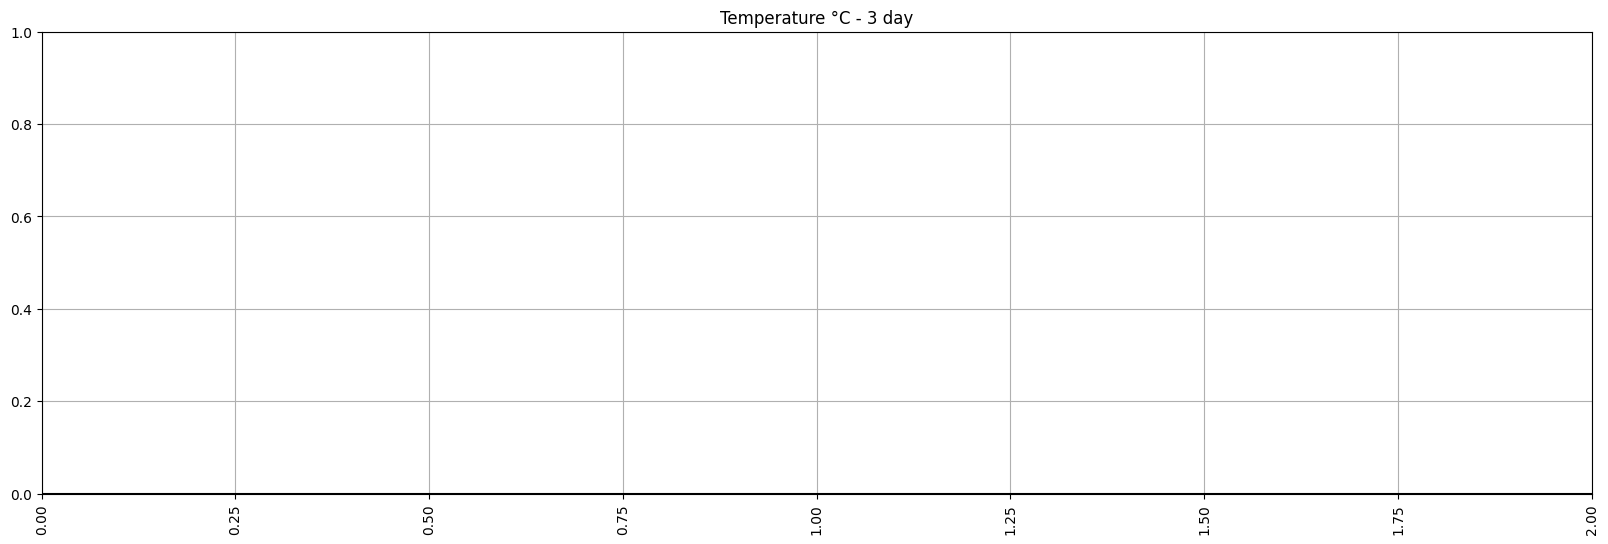

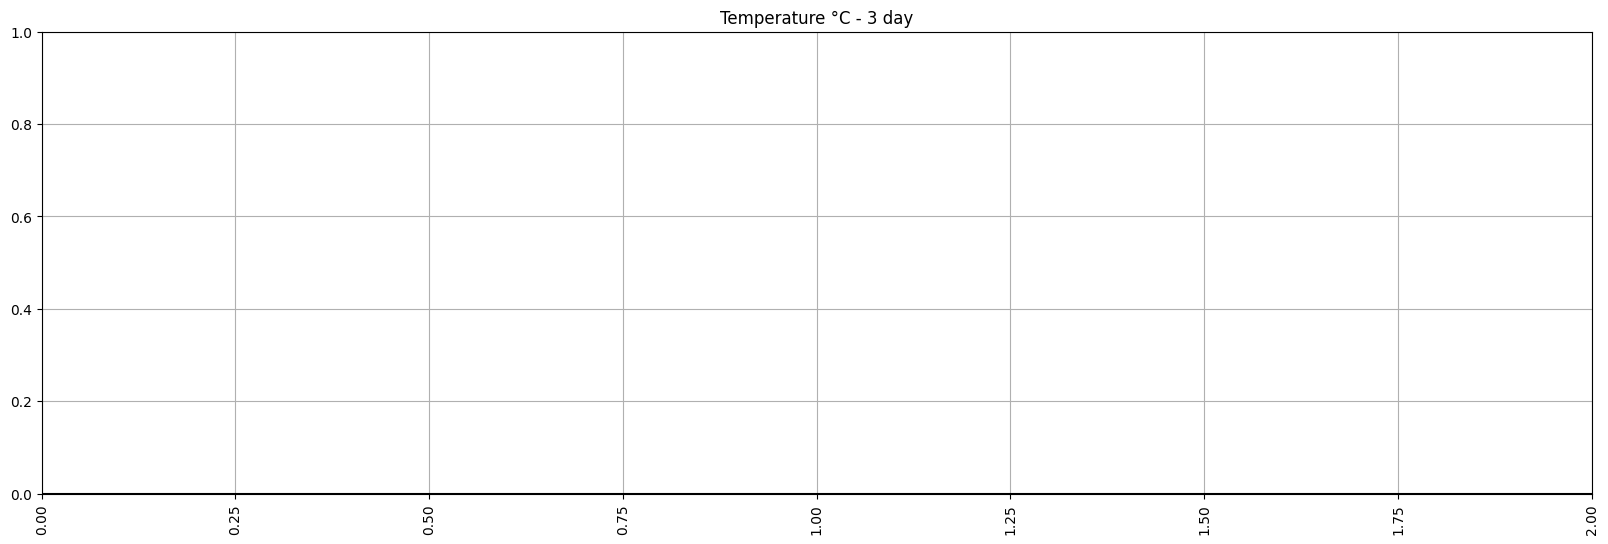

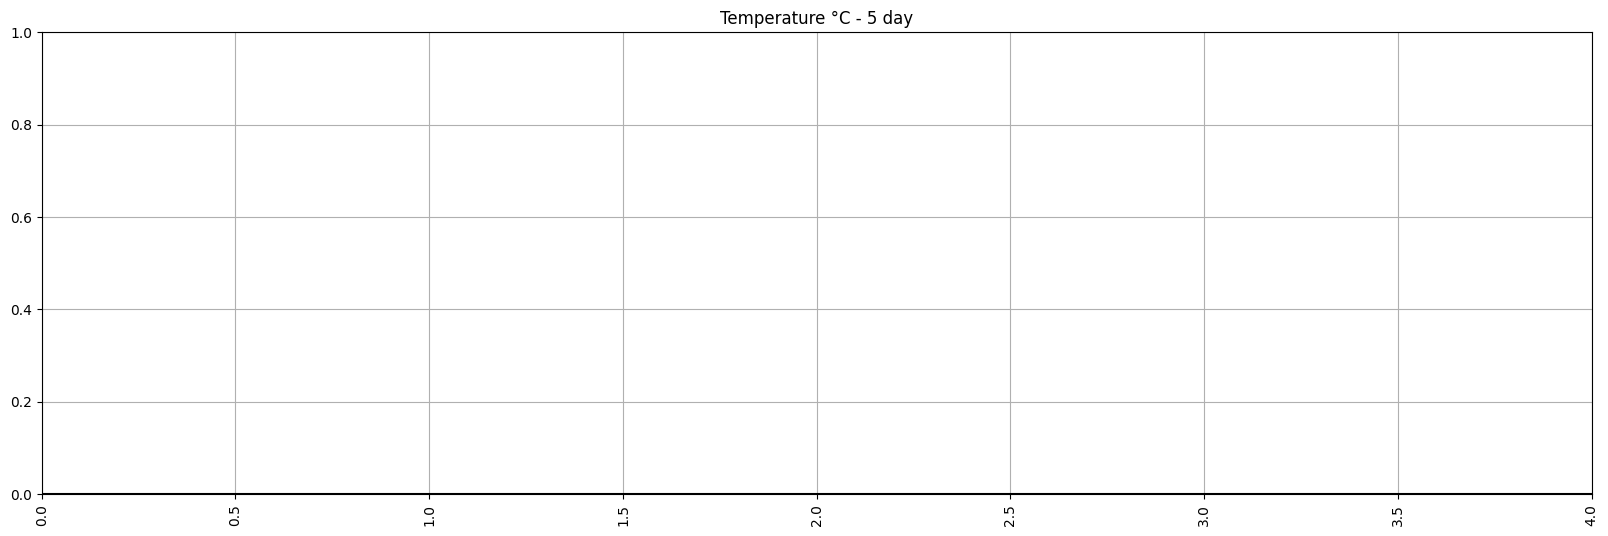

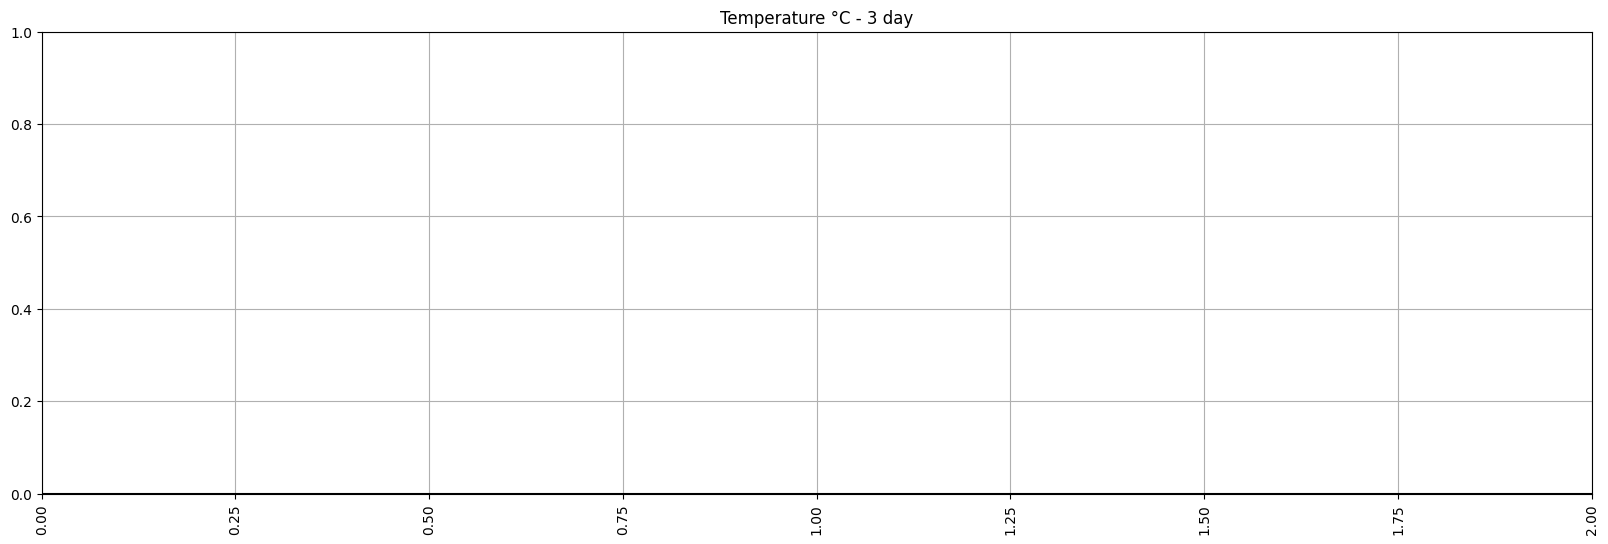

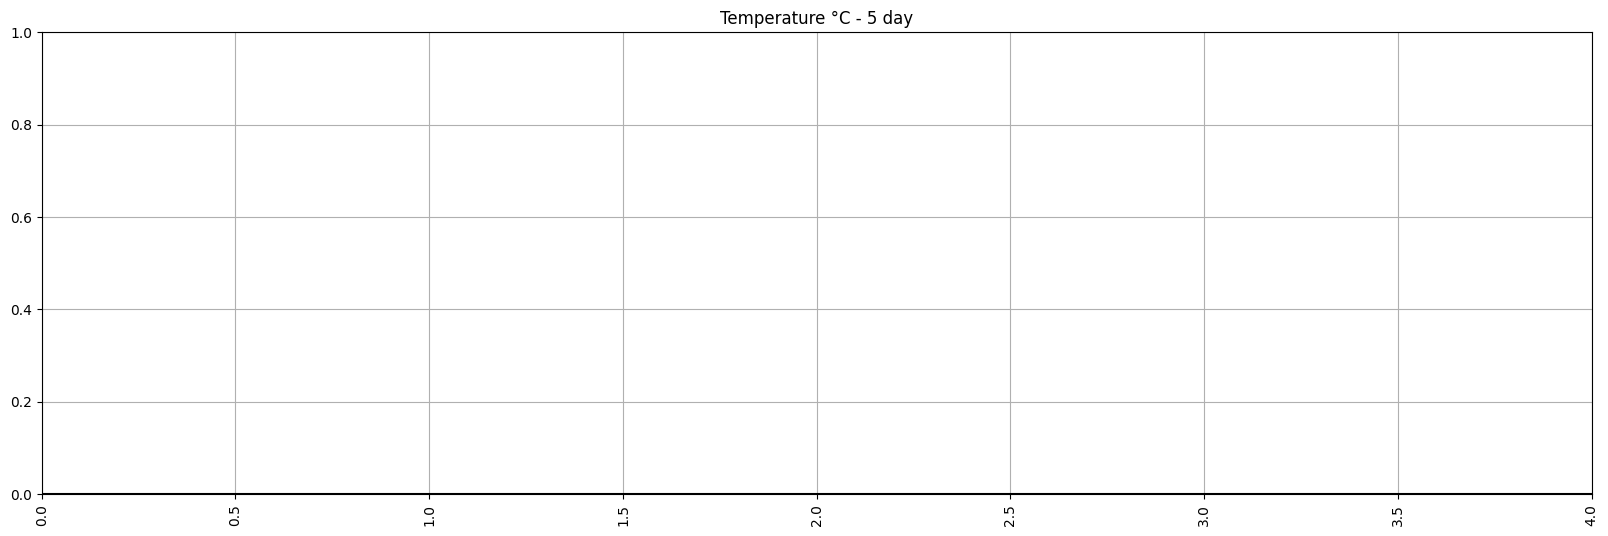

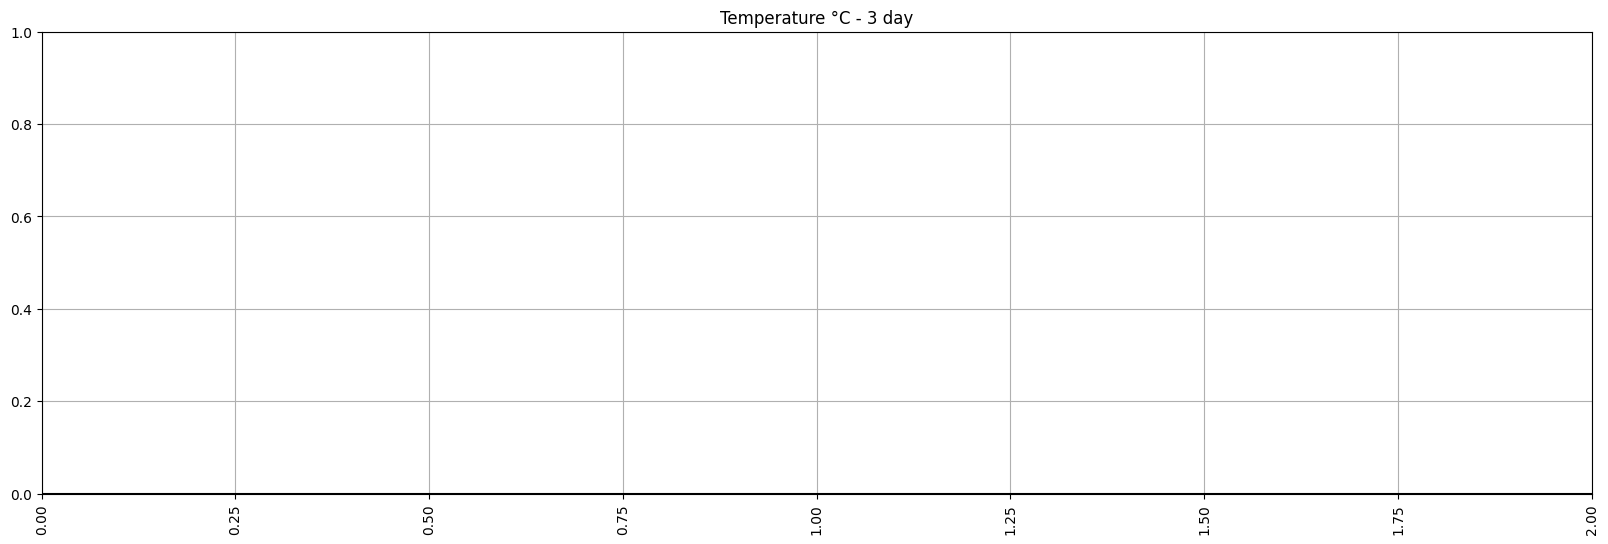

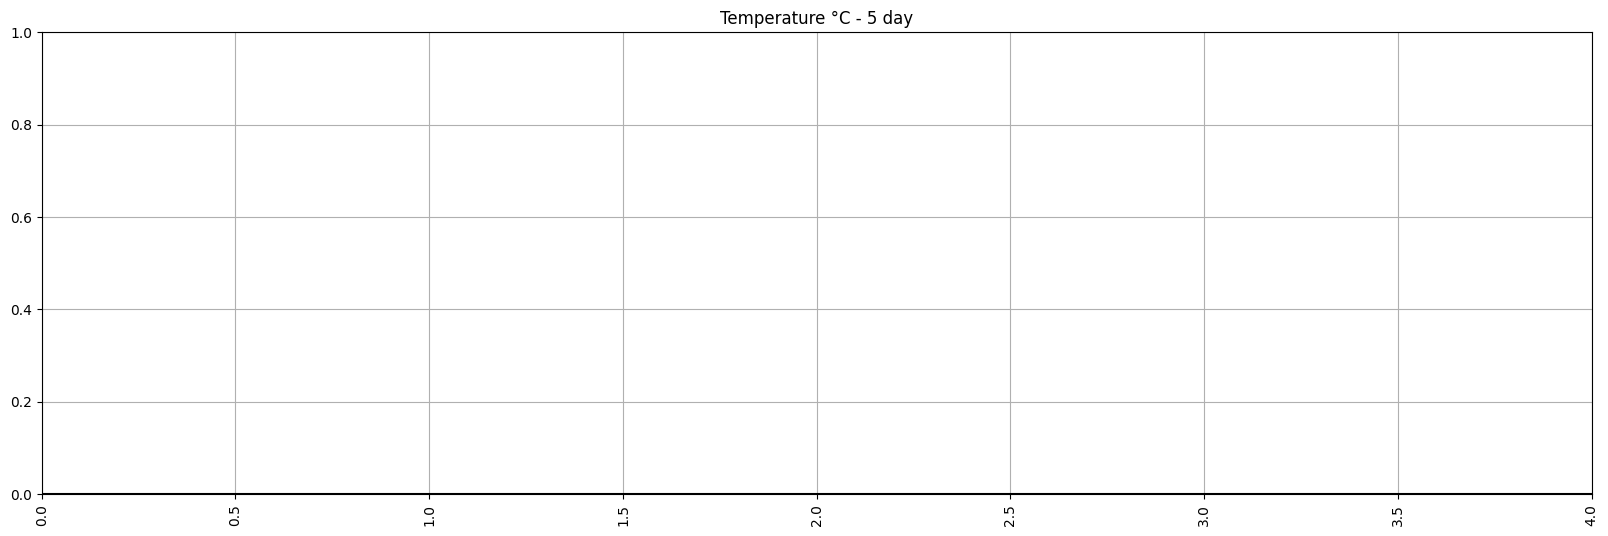

In [38]:
with alive_bar(len(dates), force_tty=True) as bar:
    for date in dates:
        for location in locations:
            plot_temps2(storage_client, location, weather_data[weather_data['Station'] == location['name']], [date], plot_range)
        bar()

In [39]:
# Create function to find missing graphs
# Create function to plot all temps together
# Create function to plot wind

In [ ]:
# Plotting Temps Error
# missing data is removed and therefore so are x axis entries
# can this wait until other issues are resolved?